# TRANSMISSION MODEL

In [1]:
import pandas as pd
import numpy as np
import math
import time
import datetime as dt
import datetime
from scipy.stats import poisson
from scipy.stats import binom
from scipy.stats import nbinom
import sys
# -*- coding: utf-8 -*-
from scipy.sparse import csr_matrix
from matplotlib.colors import hsv_to_rgb , rgb_to_hsv, LinearSegmentedColormap 
# LogNorm, LinearSegmentedColormap, ListedColormap, BoundaryNorm
import pickle
import warnings
import matplotlib.pyplot as plt

PYTHON3 = sys.version_info[0] >= 3

# load HTML engine, if it exists
try:
    if __IPYTHON__:
        from IPython.core.display import HTML
    else:
        HTML = lambda x : x
except NameError:
    HTML = lambda x : x

In [2]:
now = dt.datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 14:57:40


## Import functions

In [3]:
#########################################################################################

#compute median and CI

def add_median_CI(DF):
    df = DF.copy()
    df['p1'] = df[[i for i in range(n_runs)]].quantile(0.025, axis=1)
    df['median'] = df[[i for i in range(n_runs)]].median(axis=1)
    df['p2'] = df[[i for i in range(n_runs)]].quantile(0.975, axis=1)
    return df

#########################################################################################

# functions to read and manipulate the matrix

#reshape the array in a 4x4 matrix
def keep(df):
    C = []
    for i in range(ages*ages):
        c = df[0][i]
        C.append(c)
    C = np.array(C)
    C = np.reshape(C, (ages,ages))
    return C

#construct the four contact matrices
def extract_matrix(matrix, x_test_a,x_test_s):
    wd = keep(matrix) # healthy behavior (matrix for the individuals in the prodromic phase)
    wd_as = x_test_a*keep(matrix)*0.1 + (1-x_test_a)*keep(matrix)      # asymptomatic
    wd_t = x_test_s*keep(matrix)*0.1 + (1-x_test_s)*keep(matrix)       # pauci-symptomatic and mild
    wd_s = x_test_s*keep(matrix)*0.1 + (1-x_test_s)*keep(matrix)*0.25  # severe symptoms

    return wd,wd_as,wd_t,wd_s

#########################################################################################

def seir(u, parms, t, intervention,     #intervention is a boolean that activates LD1 and the exit strategies 
         LD, TW, scale1, scale2,
         BS_wd, BS_wd_as, BS_wd_t, BS_wd_s,   #matrices for the pre-pandemic phase
         LD_wd, LD_wd_as, LD_wd_t, LD_wd_s,
         TW_wd, TW_wd_as, TW_wd_t, TW_wd_s,   #(list of) weekly matrices for the exit phase (from May 11) 
         projections, proj_scenario, 
         fit_delay_LD2, LD2):

    #quantities of interest
    S = u['S']

    new_E = u['Y_E']
    E = u['E']
    new_I_p = u['Y_I_p']
    I_p = u['I_p']
    new_I_as = u['Y_I_as']
    I_as = u['I_as']
    new_I_ps = u['Y_I_ps']
    I_ps = u['I_ps']
    new_I_ms = u['Y_I_ms']
    I_ms = u['I_ms']
    new_I_ss = u['Y_I_ss']
    I_ss = u['I_ss']
    new_W = u['Y_W']
    W = u['W']
    new_H = u['Y_H']
    H = u['H']
    new_R = u['Y_R']
    R = u['R']
    new_V = u['Y_V']
    
    new_ABpre = u['Y_ABpre']
    ABpre = u['ABpre']
    new_ABpos = u['Y_ABpos']
    ABpos = u['ABpos']
    new_ABneg = u['Y_ABneg']
    ABneg = u['ABneg']
    
    N_tot = u['N_tot']

    bet, sigm, thet, gamm, N, dt = parms
    
    # baseline scenario
    C_h = BS_wd*seasonal[t]
    C_as = BS_wd_as*seasonal[t]
    C_t = BS_wd_t*seasonal[t]
    C_s = BS_wd_s*seasonal[t]
                                      
    if intervention:        
        for i in range(len(LD)):
            LD_start = LD[i][0]
            LD_end = LD[i][1]            
            if (t >= LD_start) and (t < LD_end):
                C_h = LD_wd*scale1*seasonal[t]
                C_as = LD_wd_as*scale1*seasonal[t]
                C_t = LD_wd_t*scale1*seasonal[t]
                C_s = LD_wd_s*scale1*seasonal[t]
                
        if weeks[0]!=20:
            print('Error: weeks vector must start with 20')
            sys.exit()
            
        if LD_end != TW[20][0]:
            print(LD_end)
            print(TW)
            print('Error: LD1 must end on May 11')
            sys.exit()
                
        for week in weeks:
            stage0_start = TW[week][0]
            stage0_end = TW[week][1]

            if (t >= stage0_start) and (t < stage0_end):
                C_h = TW_wd[week]*scale2[week]*seasonal[t]
                C_as = TW_wd_as[week]*scale2[week]*seasonal[t]
                C_t = TW_wd_t[week]*scale2[week]*seasonal[t]
                C_s = TW_wd_s[week]*scale2[week]*seasonal[t]
                
        if t>=TW[weeks[-1]][1]:
            C_h = TW_wd[weeks[-1]]*scale2[weeks[-1]]*seasonal[t]
            C_as = TW_wd_as[weeks[-1]]*scale2[weeks[-1]]*seasonal[t]
            C_t = TW_wd_t[weeks[-1]]*scale2[weeks[-1]]*seasonal[t]
            C_s = TW_wd_s[weeks[-1]]*scale2[weeks[-1]]*seasonal[t]
            
        if fit_delay_LD2 == True:
            
            LD2_start = LD2[0]
            LD2_end = LD2[1]
                
            if (t>=TW[45][0]) and (t <LD2_start):

                C_h = TW_wd[44]*scale2[44]*seasonal[t]
                C_as = TW_wd_as[44]*scale2[44]*seasonal[t]
                C_t = TW_wd_t[44]*scale2[44]*seasonal[t]
                C_s = TW_wd_s[44]*scale2[44]*seasonal[t]           
                
            if (t >= LD2_start) and (t < LD2_end):
                C_h = TW_wd[45]*scale2[45]*seasonal[t]
                C_as = TW_wd_as[45]*scale2[45]*seasonal[t]
                C_t = TW_wd_t[45]*scale2[45]*seasonal[t]
                C_s = TW_wd_s[45]*scale2[45]*seasonal[t]  
            
    # situation at the previous timestep
    lambd = {'wild': [0]*ages, 'VOC':[0]*ages, 
             'wild_vax_half': [0]*ages, 'VOC_vax_half':[0]*ages,
             'wild_vax_full': [0]*ages, 'VOC_vax_full':[0]*ages}
    
    eta = {'wild': 1.0, 'VOC': trans_increase}
    eta['wild_vax_half']=eta['wild']*(1.0-alpha_trans['wild_half'])
    eta['VOC_vax_half']=eta['VOC']*(1.0-alpha_trans['VOC_half'])
    eta['wild_vax_full']=eta['wild']*(1.0-alpha_trans['wild_full'])
    eta['VOC_vax_full']=eta['VOC']*(1.0-alpha_trans['VOC_full'])
    
    for strain in ['wild','VOC','wild_vax_half','VOC_vax_half','wild_vax_full','VOC_vax_full']:
        for age in range(ages):
            l = 0
            for age2 in range(ages):
                l += eta[strain]*susc[strain][age]*r[age2]*bet*C_h[age,age2]*I_p[strain][age2]/N
                l += eta[strain]*susc[strain][age]*r[age2]*bet*C_as[age,age2]*I_as[strain][age2]/N
                l += eta[strain]*susc[strain][age]*r[age2]*bet*C_t[age,age2]*I_ps[strain][age2]/N
                l += eta[strain]*susc[strain][age]*bet*C_t[age,age2]*I_ms[strain][age2]/N
                l += eta[strain]*susc[strain][age]*bet*C_s[age,age2]*I_ss[strain][age2]/N
            lambd[strain][age] = l
        lambd[strain] = np.array(lambd[strain])
    
    # compute transition probabilities for entering in each comparment
    tot_lambd_wild = lambd['wild']+lambd['wild_vax_half']+lambd['wild_vax_full']
    tot_lambd_VOC = lambd['VOC']+lambd['VOC_vax_half']+lambd['VOC_vax_full']
    in_E = {'wild': 1.0 - np.exp(-tot_lambd_wild*dt), 
            'VOC': 1.0 - np.exp(-tot_lambd_VOC*dt),
            'wild_vax_half': 1.0 - np.exp(-tot_lambd_wild*dt*(1.0-alpha_infect['wild_half'])),
            'VOC_vax_half': 1.0 - np.exp(-tot_lambd_VOC*dt*(1.0-alpha_infect['VOC_half'])),
            'wild_vax_full': 1.0 - np.exp(-tot_lambd_wild*dt*(1.0-alpha_infect['wild_full'])),
            'VOC_vax_full': 1.0 - np.exp(-tot_lambd_VOC*dt*(1.0-alpha_infect['VOC_full']))}
    
    in_I_p={}
    in_I={}
    in_R={}
    in_W={}
    in_H={}
    in_R_from_H={}
    
    in_ABpos={}
    in_ABneg={}

    for strain in ['wild','VOC',
                   'wild_vax_half','VOC_vax_half',
                   'wild_vax_full','VOC_vax_full']:
        in_I_p[strain]=np.array([sigm*dt]*ages)
        in_I[strain]=np.array([thet*dt]*ages)
        in_R[strain]=np.array([gamm*dt]*ages)
        
        in_W[strain]=np.array([gamm*dt]*ages)
        in_H[strain]=np.array([rate_w*dt]*ages)
        in_R_from_H[strain]=np.array([rate_hosp*dt]*ages)
        
        in_ABpos[strain]=np.array([exit_ABpre*dt]*ages)
        in_ABneg[strain]=np.array([exit_ABpos*dt]*ages)
    
    # transition events (sampled by binomial or multinomial distributions with corresponding transition probabilities)
    
    # infections events
    for age in range(ages):
        #non vaccinated
        force_of_infection = np.array([in_E['wild'][age],in_E['VOC'][age],
                                       1.0-in_E['wild'][age]-in_E['VOC'][age]])
        #print(force_of_infection)
        
        new_E['wild'][age],new_E['VOC'][age],res = np.random.multinomial(S['no_vax'][age],force_of_infection)
        
        #vaccinated half
        force_of_infection = np.array([in_E['wild_vax_half'][age],in_E['VOC_vax_half'][age],
                                       1.0-in_E['wild_vax_half'][age]-in_E['VOC_vax_half'][age]])
        new_E['wild_vax_half'][age],new_E['VOC_vax_half'][age],res = np.random.multinomial(S['vax_half'][age],
                                                                                           force_of_infection)
        #print(force_of_infection)
        
        #vaccinated full
        force_of_infection = np.array([in_E['wild_vax_full'][age],in_E['VOC_vax_full'][age],
                                       1.0-in_E['wild_vax_full'][age]-in_E['VOC_vax_full'][age]])
        new_E['wild_vax_full'][age],new_E['VOC_vax_full'][age],res = np.random.multinomial(S['vax_full'][age],
                                                                                           force_of_infection)
        #print(force_of_infection)
        
    #spontaneous transitions
    
    recovery_as = {}
    recovery_ps = {}
    recovery_ms = {}
    recovery_h = {}
    
    if t < VOC_origin:
        list_strains=['wild']
    elif t < start_vaccination:
        list_strains=['wild','VOC']
    else:
        list_strains=['wild','VOC','wild_vax_half','VOC_vax_half','wild_vax_full','VOC_vax_full']
        
    for strain in list_strains:
        recovery_as[strain] = [0]*ages
        recovery_ps[strain] = [0]*ages
        recovery_ms[strain] = [0]*ages
        recovery_h[strain] = [0]*ages
        
        for age in range(ages):
            new_I_p[strain][age] = np.random.binomial(E[strain][age],in_I_p[strain][age])

            trans_I = np.array([p_as_v[strain][age]*in_I[strain][age], 
                                p_ps_v[strain][age]*in_I[strain][age], 
                                p_ms_v[strain][age]*in_I[strain][age], 
                                p_ss_v[strain][age]*in_I[strain][age], 
                                1.-in_I[strain][age]])
            #print(trans_I)
            new_I_as[strain][age], new_I_ps[strain][age], new_I_ms[strain][age], new_I_ss[strain][age], res = np.random.multinomial(I_p[strain][age],trans_I)

            recovery_as[strain][age] = np.random.binomial(I_as[strain][age],in_R[strain][age])
            recovery_ps[strain][age] = np.random.binomial(I_ps[strain][age],in_R[strain][age])
            recovery_ms[strain][age] = np.random.binomial(I_ms[strain][age],in_R[strain][age])

            new_W[strain][age] = np.random.binomial(I_ss[strain][age],in_W[strain][age])
            new_H[strain][age] = np.random.binomial(W[strain][age],in_H[strain][age])
            recovery_h[strain][age] = np.random.binomial(H[strain][age], in_R_from_H[strain][age])
            
            new_R[strain][age] = recovery_as[strain][age] + recovery_ps[strain][age] + recovery_ms[strain][age] + recovery_h[strain][age]

            new_ABpre[strain][age] = new_I_p[strain][age]
            new_ABpos[strain][age] = np.random.binomial(ABpre[strain][age],in_ABpos[strain][age])
            new_ABneg[strain][age] = np.random.binomial(ABpos[strain][age],in_ABneg[strain][age])

    #update compartments
    
    for age in range(ages):  
        
        S['no_vax'][age] = S['no_vax'][age] - new_E['wild'][age] - new_E['VOC'][age]
        S['vax_half'][age] = S['vax_half'][age] - new_E['wild_vax_half'][age] - new_E['VOC_vax_half'][age] 
        S['vax_full'][age] = S['vax_full'][age] - new_E['wild_vax_full'][age] - new_E['VOC_vax_full'][age] 
        
        for strain in list_strains:      
            E[strain][age] = E[strain][age] + new_E[strain][age] - new_I_p[strain][age]
            I_p[strain][age] = I_p[strain][age] + new_I_p[strain][age] - new_I_as[strain][age] - new_I_ps[strain][age] - new_I_ms[strain][age] - new_I_ss[strain][age]
            I_as[strain][age] = I_as[strain][age] + new_I_as[strain][age] - recovery_as[strain][age]
            I_ps[strain][age] = I_ps[strain][age] + new_I_ps[strain][age] - recovery_ps[strain][age]
            I_ms[strain][age] = I_ms[strain][age] + new_I_ms[strain][age] - recovery_ms[strain][age]
            I_ss[strain][age] = I_ss[strain][age] + new_I_ss[strain][age] - new_W[strain][age]
            W[strain][age] = W[strain][age] + new_W[strain][age] - new_H[strain][age]
            H[strain][age] = H[strain][age] + new_H[strain][age] - recovery_h[strain][age]
            R[strain][age] = R[strain][age] + new_R[strain][age]
            ABpre[strain][age] = ABpre[strain][age] + new_ABpre[strain][age] - new_ABpos[strain][age]
            ABpos[strain][age] = ABpos[strain][age] + new_ABpos[strain][age] - new_ABneg[strain][age]
            ABneg[strain][age] = ABneg[strain][age] + new_ABneg[strain][age]
            
        tag = 'wild'
        wild_compts = E[tag][age]+I_p[tag][age]+I_as[tag][age]+I_ps[tag][age]+I_ms[tag][age]+I_ss[tag][age]+W[tag][age]+H[tag][age]+R[tag][age]
        tag='VOC'
        VOC_compts = E[tag][age]+I_p[tag][age]+I_as[tag][age]+I_ps[tag][age]+I_ms[tag][age]+I_ss[tag][age]+W[tag][age]+H[tag][age]+R[tag][age]
        tag='wild_vax_half'
        wild_compts_vax_half = E[tag][age]+I_p[tag][age]+I_as[tag][age]+I_ps[tag][age]+I_ms[tag][age]+I_ss[tag][age]+W[tag][age]+H[tag][age]+R[tag][age]
        tag='VOC_vax_half'
        VOC_compts_vax_half =  E[tag][age]+I_p[tag][age]+I_as[tag][age]+I_ps[tag][age]+I_ms[tag][age]+I_ss[tag][age]+W[tag][age]+H[tag][age]+R[tag][age]
        tag='wild_vax_full'
        wild_compts_vax_full = E[tag][age]+I_p[tag][age]+I_as[tag][age]+I_ps[tag][age]+I_ms[tag][age]+I_ss[tag][age]+W[tag][age]+H[tag][age]+R[tag][age]
        tag='VOC_vax_full'
        VOC_compts_vax_full =  E[tag][age]+I_p[tag][age]+I_as[tag][age]+I_ps[tag][age]+I_ms[tag][age]+I_ss[tag][age]+W[tag][age]+H[tag][age]+R[tag][age]
        
        N_tot[age] = S['no_vax'][age] + S['vax_half'][age] + S['vax_full'][age] + wild_compts + VOC_compts + wild_compts_vax_half + VOC_compts_vax_half + wild_compts_vax_full + VOC_compts_vax_full
   
    if t == wild_origin:
        sys.exit()
        #initialize wild 
        #for ii,gg in enumerate(['ch', 'te', 'ad', 'se']):
        #    E['wild'][ii] = int(np.around(dict_config_wild['E_{}'.format(gg)]))
        #    I_p['wild'][ii] = int(np.around(dict_config_wild['Ip_{}'.format(gg)]))
        #    I_as['wild'][ii] = int(np.around(dict_config_wild['Ias_{}'.format(gg)]))
        #    I_ps['wild'][ii] = int(np.around(dict_config_wild['Ips_{}'.format(gg)]))
        #    I_ms['wild'][ii] = int(np.around(dict_config_wild['Ims_{}'.format(gg)]))
        #    I_ss['wild'][ii] = int(np.around(dict_config_wild['Iss_{}'.format(gg)]))
        #    H['wild'][ii] = int(np.around(dict_config_wild['H_{}'.format(gg)]))
        #    R['wild'][ii] = int(np.around(dict_config_wild['R_{}'.format(gg)]))
        #    remove = E['wild'][ii]+I_p['wild'][ii]+I_as['wild'][ii]+I_ps['wild'][ii]+I_ms['wild'][ii]+I_ss['wild'][ii]+H['wild'][ii]+R['wild'][ii]
        #    S['no_vax'][ii] = S['no_vax'][ii]-remove
            
    ### insert a VOC case at the end of the day in the third age class (adults):
    if t == VOC_origin: 
        for age in range(ages):

            strain = 'wild'
            E_tot = E[strain][age]
            I_p_tot = I_p[strain][age]
            I_as_tot = I_as[strain][age]
            I_ps_tot = I_ps[strain][age]
            I_ms_tot = I_ms[strain][age]
            I_ss_tot = I_ss[strain][age]

            strain = 'wild'
            E[strain][age] = int(np.around(E_tot*(1.-prevalence/100.)))
            I_p[strain][age] = int(np.around(I_p_tot*(1.-prevalence/100.)))
            I_as[strain][age] = int(np.around(I_as_tot*(1.-prevalence/100.)))
            I_ps[strain][age] = int(np.around(I_ps_tot*(1.-prevalence/100.)))
            I_ms[strain][age] = int(np.around(I_ms_tot*(1.-prevalence/100.)))
            I_ss[strain][age] = int(np.around(I_ss_tot*(1.-prevalence/100.)))
            
            strain = 'VOC'
            E[strain][age] = int(np.around(E_tot*(prevalence/100.)))
            I_p[strain][age] = int(np.around(I_p_tot*(prevalence/100.)))
            I_as[strain][age] = int(np.around(I_as_tot*(prevalence/100.)))
            I_ps[strain][age] = int(np.around(I_ps_tot*(prevalence/100.)))
            I_ms[strain][age] = int(np.around(I_ms_tot*(prevalence/100.)))
            I_ss[strain][age] = int(np.around(I_ss_tot*(prevalence/100.)))
            
    if t == start_vaccination:
        #put vaccination (dynamic)
        for age in [2,3]:
            if age == 1: #adolescents
                sys.exit()
                #coverage = init_coverage_teen
                #N_age = N_t
            elif age == 2: #adults
                coverage = init_coverage_adu
                N_age = N_a
            elif age ==3: #seniors
                coverage = init_coverage_sen
                N_age = N_s
            else:
                sys.exit()

            vaccinati_full = int(np.around(N_age*coverage['full']))
            vaccinati_half = int(np.around(N_age*coverage['half']))-vaccinati_full
            
            vaccinabili = S['no_vax'][age]+R['wild'][age]+R['VOC'][age]
            #extract from S and R the individuals with 1 DOSE
            trans_vax = np.array([S['no_vax'][age]/float(vaccinabili),
                                R['wild'][age]/float(vaccinabili),
                                R['VOC'][age]/float(vaccinabili),0])
            #scelgo i gia vaccinati dentro S e R proporzionalmente
            new_S_vax, new_R_wild_vax, new_R_VOC_vax, res = np.random.multinomial(vaccinati_half, trans_vax)

            vax = min(new_S_vax, S['no_vax'][age])
            S['no_vax'][age] = S['no_vax'][age]-vax  
            S['vax_half'][age] = S['vax_half'][age]+vax
            
            vax = min(new_R_wild_vax, R['wild'][age])
            R['wild'][age] = R['wild'][age]-vax
            R['wild_vax_half'][age] = R['wild_vax_half'][age]+vax
            
            vax = min(new_R_VOC_vax, R['VOC'][age])
            R['VOC'][age] = R['VOC'][age]-vax
            R['VOC_vax_half'][age] = R['VOC_vax_half'][age]+vax
            
            #extract from S and R the individuals with 2 DOSES
            trans_vax = np.array([S['no_vax'][age]/float(vaccinabili),
                                R['wild'][age]/float(vaccinabili),
                                R['VOC'][age]/float(vaccinabili),0])
            #scelgo i gia vaccinati dentro S e R proporzionalmente
            new_S_vax, new_R_wild_vax, new_R_VOC_vax, res = np.random.multinomial(vaccinati_full, trans_vax)
            
            vax = min(new_S_vax, S['no_vax'][age])
            S['no_vax'][age] = S['no_vax'][age]-vax  
            S['vax_full'][age] = S['vax_full'][age]+vax
            
            vax = min(new_R_wild_vax, R['wild'][age])
            R['wild'][age] = R['wild'][age]-vax
            R['wild_vax_full'][age] = R['wild_vax_full'][age]+vax
            
            vax = min(new_R_VOC_vax, R['VOC'][age])
            R['VOC'][age] = R['VOC'][age]-vax
            R['VOC_vax_full'][age] = R['VOC_vax_full'][age]+vax
        
    if t > start_vaccination:
        # continue with vaccination
        # administer doses according to data
        one_week=7
        for age in [2,3]:
            for i, week in enumerate(np.arange(weeks[0], weeks[-1]+100)):
                stage0_start = i*one_week+1
                stage0_end = (i+1)*one_week+1
                
                if (t >= stage0_start) and (t < stage0_end):
                    current_week = week 
                    break       
                    
            # exact daily doses delivered, according to the data on vaccination
            
            if age == 1: 
                sys.exit()
                N_age = N_t
                max_cov = max_coverage['teen']
                tag_age = 'teen'
            elif age == 2: 
                N_age = N_a
                max_cov = max_coverage['adu']
                tag_age = 'adult'
            elif age == 3:
                N_age = N_s
                max_cov = max_coverage['sen']
                tag_age = 'senior'
            else:
                sys.exit()

            new_doses = {}

            condition = past_rollout['dt_date_eff']==(calendar.iloc[t][0]-datetime.timedelta(days=0))
            new_doses['dose1'] = int((N_age/100.)*past_rollout[condition]['%_{}_1d'.format(tag_age)].values[0])

            condition = past_rollout['dt_date_eff']==(calendar.iloc[t][0]-datetime.timedelta(days=0))
            new_doses['dose2'] = int((N_age/100.)*past_rollout[condition]['%_{}_2d'.format(tag_age)].values[0])

            #condition = past_rollout['dt_date_eff']==(calendar.iloc[t][0]-datetime.timedelta(days=0))
            #new_doses['dose3'] = int((N_age/100.)*past_rollout[condition]['%_{}_3d'.format(tag_age)].values[0])

            new_V['dose_1'][age]=0
            new_V['dose_2'][age]=0    
            ##new_V['dose_2'][age]=0                
                                  
            if current_week >= start_week_vaccine_proj+vax_delay:
                print('define how to deal with projections of vaccines')
                sys.exit()
                # TRANSIT FROM FIRTS DOSE TO SECOND DOSE COMPARTMENT 
                #in_exit_vax = 1./(7*projected_delay_inter_doses)  ## 3 weeks average time between first dose and second dose in the projected scenarios
                #exit_vax  = np.random.binomial(S['vax_half'][age],in_exit_vax)
                #S['vax_half'][age]=S['vax_half'][age]-exit_vax
                #new_V['dose_2'][age] += exit_vax
                #S['vax_full'][age]=S['vax_full'][age]+exit_vax

                #exit_vax  = np.random.binomial(R['wild_vax_half'][age],in_exit_vax)
                #R['wild_vax_half'][age]=R['wild_vax_half'][age]-exit_vax
                #new_V['dose_2'][age] += exit_vax
                #R['wild_vax_full'][age]=R['wild_vax_full'][age]+exit_vax

                #exit_vax  = np.random.binomial(R['VOC_vax_half'][age],in_exit_vax)
                #R['VOC_vax_half'][age]=R['VOC_vax_half'][age]-exit_vax
                #new_V['dose_2'][age] += exit_vax
                #R['VOC_vax_full'][age]=R['VOC_vax_full'][age]+exit_vax            
                
            # FIRST DOSES
            vaccinabili = S['no_vax'][age]+R['wild'][age]+R['VOC'][age]
            stage_vax = 'vax_half'
            perc_vacc_1 = (S[stage_vax][age]+E['VOC_{}'.format(stage_vax)][age]+I_p['VOC_{}'.format(stage_vax)][age]+I_as['VOC_{}'.format(stage_vax)][age]+I_ps['VOC_{}'.format(stage_vax)][age]+I_ms['VOC_{}'.format(stage_vax)][age]+I_ss['VOC_{}'.format(stage_vax)][age]+H['VOC_{}'.format(stage_vax)][age]+R['VOC_{}'.format(stage_vax)][age]+E['wild_{}'.format(stage_vax)][age]+I_p['wild_{}'.format(stage_vax)][age]+I_as['wild_{}'.format(stage_vax)][age]+I_ps['wild_{}'.format(stage_vax)][age]+I_ms['wild_{}'.format(stage_vax)][age]+I_ss['wild_{}'.format(stage_vax)][age]+H['wild_{}'.format(stage_vax)][age]+R['wild_{}'.format(stage_vax)][age])/N_age
            stage_vax = 'vax_full'           
            perc_vacc_2 = (S[stage_vax][age]+E['VOC_{}'.format(stage_vax)][age]+I_p['VOC_{}'.format(stage_vax)][age]+I_as['VOC_{}'.format(stage_vax)][age]+I_ps['VOC_{}'.format(stage_vax)][age]+I_ms['VOC_{}'.format(stage_vax)][age]+I_ss['VOC_{}'.format(stage_vax)][age]+H['VOC_{}'.format(stage_vax)][age]+R['VOC_{}'.format(stage_vax)][age]+E['wild_{}'.format(stage_vax)][age]+I_p['wild_{}'.format(stage_vax)][age]+I_as['wild_{}'.format(stage_vax)][age]+I_ps['wild_{}'.format(stage_vax)][age]+I_ms['wild_{}'.format(stage_vax)][age]+I_ss['wild_{}'.format(stage_vax)][age]+H['wild_{}'.format(stage_vax)][age]+R['wild_{}'.format(stage_vax)][age])/N_age
            ##stage_vax = 'vax_boost'
            ##perc_vacc_3 = (S[stage_vax][age]+E['VOC_{}'.format(stage_vax)][age]+I_p['VOC_{}'.format(stage_vax)][age]+I_as['VOC_{}'.format(stage_vax)][age]+I_ps['VOC_{}'.format(stage_vax)][age]+I_ms['VOC_{}'.format(stage_vax)][age]+I_ss['VOC_{}'.format(stage_vax)][age]+H['VOC_{}'.format(stage_vax)][age]+R['VOC_{}'.format(stage_vax)][age]+E['wild_{}'.format(stage_vax)][age]+I_p['wild_{}'.format(stage_vax)][age]+I_as['wild_{}'.format(stage_vax)][age]+I_ps['wild_{}'.format(stage_vax)][age]+I_ms['wild_{}'.format(stage_vax)][age]+I_ss['wild_{}'.format(stage_vax)][age]+H['wild_{}'.format(stage_vax)][age]+R['wild_{}'.format(stage_vax)][age])/N_age
            
            ##perc_vacc = perc_vacc_1+perc_vacc_2+perc_vacc_3
            perc_vacc = perc_vacc_1+perc_vacc_2
            
            if perc_vacc < max_cov:
                if vaccinabili > 0:
                    trans_vax = np.array([S['no_vax'][age]/float(vaccinabili), 
                                        R['wild'][age]/float(vaccinabili), 
                                        R['VOC'][age]/float(vaccinabili),0])
                else: 
                    trans_vax = np.array([0,0,0,1.])
                
                if (perc_vacc*N_age + new_doses['dose1']) < max_cov*N_age:
                    new_S_vax, new_R_wild_vax, new_R_VOC_vax, res = np.random.multinomial(new_doses['dose1'], trans_vax)
                else:
                    doses_ad_hoc = int(max_cov*N_age - perc_vacc*N_age) # which is a smaller value than new_1st_doses
                    new_S_vax, new_R_wild_vax, new_R_VOC_vax, res = np.random.multinomial(doses_ad_hoc, trans_vax)

                vax = min(new_R_wild_vax,R['wild'][age])
                new_V['dose_1'][age] += vax
                R['wild'][age] = R['wild'][age]-vax
                R['wild_vax_half'][age] = R['wild_vax_half'][age]+vax

                vax = min(new_R_VOC_vax,R['VOC'][age])
                new_V['dose_1'][age] += vax
                R['VOC'][age] = R['VOC'][age]-vax
                R['VOC_vax_half'][age] = R['VOC_vax_half'][age]+vax

                vax = min(S['no_vax'][age],new_S_vax)
                new_V['dose_1'][age] += vax
                S['no_vax'][age] = S['no_vax'][age]-vax
                S['vax_half'][age] = S['vax_half'][age]+vax
                
            if current_week < start_week_vaccine_proj+vax_delay:
                # SECOND DOSES
                vaccinabili = S['vax_half'][age]+R['wild_vax_half'][age]+R['VOC_vax_half'][age]
                #vaccinabili = S['vax_boost'][age]+R['wild_vax_boost'][age]+R['VOC_vax_boost'][age]
                
                if vaccinabili > 0:
                    trans_vax = np.array([S['vax_half'][age]/float(vaccinabili), 
                                        R['wild_vax_half'][age]/float(vaccinabili), 
                                        R['VOC_vax_half'][age]/float(vaccinabili),0])
                else: 
                    trans_vax = np.array([0,0,0,1.])

                new_S_vax, new_R_wild_vax, new_R_VOC_vax, res = np.random.multinomial(new_doses['dose2'], trans_vax)

                vax = min(new_R_wild_vax,R['wild_vax_half'][age])
                new_V['dose_2'][age] += vax
                R['wild_vax_half'][age] = R['wild_vax_half'][age]-vax
                R['wild_vax_full'][age] = R['wild_vax_full'][age]+vax

                vax = min(new_R_VOC_vax,R['VOC_vax_half'][age])
                new_V['dose_2'][age] += vax
                R['VOC_vax_half'][age] = R['VOC_vax_half'][age]-vax
                R['VOC_vax_full'][age] = R['VOC_vax_full'][age]+vax

                vax = min(S['vax_half'][age],new_S_vax)
                new_V['dose_2'][age] += vax
                S['vax_half'][age] = S['vax_half'][age]-vax
                S['vax_full'][age] = S['vax_full'][age]+vax
                
                """# THIRD DOSES
                vaccinabili = S['vax_full'][age]+R['wild_vax_full'][age]+R['VOC_vax_full'][age]
                #vaccinabili = S['vax_boost'][age]+R['wild_vax_boost'][age]+R['VOC_vax_boost'][age]
                
                if vaccinabili > 0:
                    trans_vax = np.array([S['vax_full'][age]/float(vaccinabili), 
                                        R['wild_vax_full'][age]/float(vaccinabili), 
                                        R['VOC_vax_full'][age]/float(vaccinabili),0])
                else: 
                    trans_vax = np.array([0,0,0,1.])

                if new_doses['dose3'] > 0:
                    
                    new_S_vax, new_R_wild_vax, new_R_VOC_vax, res = np.random.multinomial(new_doses['dose3'], trans_vax)

                    vax = min(new_R_wild_vax,R['wild_vax_full'][age])
                    new_V['dose_3'][age] += vax
                    R['wild_vax_full'][age] = R['wild_vax_full'][age]-vax
                    R['wild_vax_boost'][age] = R['wild_vax_boost'][age]+vax

                    vax = min(new_R_VOC_vax,R['VOC_vax_full'][age])
                    new_V['dose_3'][age] += vax
                    R['VOC_vax_full'][age] = R['VOC_vax_full'][age]-vax
                    R['VOC_vax_boost'][age] = R['VOC_vax_boost'][age]+vax

                    vax = min(S['vax_full'][age],new_S_vax)
                    new_V['dose_3'][age] += vax
                    S['vax_full'][age] = S['vax_full'][age]-vax
                    S['vax_boost'][age] = S['vax_boost'][age]+vax"""

            
    return  {'t':t, 'S': S, 'E':E, 'I_p':I_p, 
             'I_as':I_as,'I_ps':I_ps,'I_ms':I_ms,'I_ss':I_ss, 'H':H, 'R':R,
             'Y_E':new_E,'Y_I_p':new_I_p,'Y_I_as':new_I_as,
             'Y_I_ps':new_I_ps,'Y_I_ms':new_I_ms,'Y_I_ss':new_I_ss,
             'Y_H':new_H, 'Y_R':new_R, 
             'Y_V': new_V, 
             'Y_W': new_W, 'W': W,
             'ABpre':ABpre, 'ABpos':ABpos, 'ABneg':ABneg, 
             'Y_ABpre':new_ABpre, 'Y_ABpos':new_ABpos, 'Y_ABneg':new_ABneg, 
             'N_tot':N_tot}

def simulate(beta,lag,intervention, 
             LD, TW, scale1,scale2,
             BS_wd,BS_wd_as, BS_wd_t, BS_wd_s,
             LD_wd,LD_wd_as, LD_wd_t, LD_wd_s,
             TW_wd,TW_wd_as, TW_wd_t, TW_wd_s,
             projections, proj_scenario, 
             fit_delay_LD2, LD2):
    
    parms = [beta, sigma, theta, gamma, N, delta_t]
    
    tf = t_stop
    
    t = np.arange(tf)
    
    S = {'no_vax' : np.zeros((tf,ages)), 
         'vax_half' : np.zeros((tf,ages)),
         'vax_full' : np.zeros((tf,ages))} 
    
    Y_V= {'dose_1' : np.zeros((tf,ages)),
          'dose_2' : np.zeros((tf,ages))} 
    
    E={}
    I_p={}
    I_as={}
    I_ps={}
    I_ms={}
    I_ss={}
    W={}
    H={}
    R={}
    Y_E={}
    Y_I_p={}
    Y_I_as={}
    Y_I_ps={}
    Y_I_ms={}
    Y_I_ss={}
    Y_W={}
    Y_H={}
    Y_R={}
    
    ABpre={}
    ABpos={}
    ABneg={}
    Y_ABpre={}
    Y_ABpos={}
    Y_ABneg={}
    
    for strain in ['wild','VOC',
                   'wild_vax_half','VOC_vax_half',
                   'wild_vax_full','VOC_vax_full']:
                                
        E[strain]=np.zeros((tf,ages))
        I_p[strain]=np.zeros((tf,ages))
        I_as[strain]=np.zeros((tf,ages))
        I_ps[strain]=np.zeros((tf,ages))
        I_ms[strain]=np.zeros((tf,ages))
        I_ss[strain]=np.zeros((tf,ages))
        W[strain]=np.zeros((tf,ages))
        H[strain]=np.zeros((tf,ages))
        R[strain]=np.zeros((tf,ages))
        
        Y_E[strain]=np.zeros((tf,ages))
        Y_I_p[strain]=np.zeros((tf,ages))
        Y_I_as[strain]=np.zeros((tf,ages))
        Y_I_ps[strain]=np.zeros((tf,ages))
        Y_I_ms[strain]=np.zeros((tf,ages))
        Y_I_ss[strain]=np.zeros((tf,ages))
        Y_W[strain]=np.zeros((tf,ages))
        Y_H[strain]=np.zeros((tf,ages))
        Y_R[strain]=np.zeros((tf,ages))
        
        ABpre[strain]=np.zeros((tf,ages))
        Y_ABpre[strain]=np.zeros((tf,ages))
        ABpos[strain]=np.zeros((tf,ages))
        Y_ABpos[strain]=np.zeros((tf,ages))
        ABneg[strain]=np.zeros((tf,ages))
        Y_ABneg[strain]=np.zeros((tf,ages))
    
    N_tot = np.zeros((tf,ages))
    
    result = {'t':t, 'S': S, 
              'E':E, 'I_p':I_p, 
              'I_as':I_as,'I_ps':I_ps,'I_ms':I_ms,'I_ss':I_ss, 'W':W, 'H':H,'R':R,
              'Y_E':Y_E,'Y_I_p':Y_I_p,
              'Y_I_as':Y_I_as,'Y_I_ps':Y_I_ps,'Y_I_ms':Y_I_ms,'Y_I_ss':Y_I_ss,
              'Y_H':Y_H,'Y_R':Y_R,'Y_V': Y_V, 'Y_W': Y_W, 
              'ABpre':ABpre, 'ABpos':ABpos, 'ABneg':ABneg, 
              'Y_ABpre':Y_ABpre, 'Y_ABpos':Y_ABpos, 'Y_ABneg':Y_ABneg,
              'N_tot':N_tot}
                                
    #initial condition
    
    u = {'t':0, 
         'S': {'no_vax': [N_c,N_t,N_a-I_iniz,N_s], 'vax_half': [0,0,0,0], 'vax_full': [0,0,0,0]}, 
         'Y_V': {'dose_1' : [0]*ages, 'dose_2' : [0]*ages, 'dose_3' : [0]*ages},
         'E':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'I_p':{'wild':[0,0,I_iniz,0],'VOC':[0]*ages,                 
                'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'I_as':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'I_ps':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'I_ms':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'I_ss':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'W':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'H':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'R':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'Y_E':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'Y_I_p':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'Y_I_as':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'Y_I_ps':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'Y_I_ms':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'Y_I_ss':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'Y_W':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'Y_H':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'Y_R':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'Y_ABpre':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'ABpre':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'Y_ABpos':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'ABpos':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'Y_ABneg':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'ABneg':{'wild':[0]*ages,'VOC':[0]*ages,
                 'wild_vax_half':[0]*ages,'VOC_vax_half':[0]*ages,
                 'wild_vax_full':[0]*ages,'VOC_vax_full':[0]*ages},
         'N_tot':[N_c,N_t,N_a,N_s]}

    for c in result.keys():
        #e.g. result['I_p'] is a dictionary with two keys, wild and VOC
        #result['I_p']['wild'] is an array with length = t_stop
        #each elements is a list with length = ages
        #result['I_p']['wild'] is initialized with zeros
        #I insert in the first position the list [0,0,I_iniz,0] which indicates the initial condition
        if c not in ['t','S','N_tot', 'Y_V']:
            for strain in ['wild','VOC','wild_vax_half','VOC_vax_half','wild_vax_full','VOC_vax_full']:
                result[c][strain][0] = u[c][strain]
        elif c =='S':
            for status in ['no_vax', 'vax_half', 'vax_full']:
                result[c][status][0] = u[c][status]
        elif c=='Y_V':
            for status in ['dose_1', 'dose_2']:
                result[c][status][0] = u[c][status]     
        else:
            result[c][0] = u[c]
    
    for j in range(1,tf):
        #j is the time index
        u = seir(u,parms,t[j],intervention, LD, TW, scale1,scale2,
                 BS_wd,BS_wd_as, BS_wd_t, BS_wd_s,
                 LD_wd,LD_wd_as, LD_wd_t, LD_wd_s,
                 TW_wd,TW_wd_as, TW_wd_t, TW_wd_s,
                 projections, proj_scenario,
                 fit_delay_LD2, LD2) 
        
        for c in result.keys():#list of compartments
            #I insert in position j the list [x,x,x,x] which indicates number of individuals 
            #in compartment c with strain at the timestep j
            if c not in ['t','S','N_tot', 'Y_V']:
                for strain in ['wild','VOC','wild_vax_half','VOC_vax_half','wild_vax_full','VOC_vax_full']:
                    result[c][strain][j] = u[c][strain]
            elif c =='S':
                for status in ['no_vax', 'vax_half', 'vax_full']:
                    result[c][status][j] = u[c][status]
            elif c=='Y_V':
                for status in ['dose_1', 'dose_2']:
                    result[c][status][j] = u[c][status]     
            else:
                result[c][j] = u[c]
    
            
    return result

def run_simulation(beta,lag,fit_delay_LD2, LD2,
                   intervention = False, 
                   LD = [[0,0]], TW = 0,
                   scale1=0,scale2=0,
                   x_test_a=0,x_test_s=0, 
                   projections = False, proj_scenario = 'none'):
    
    #read matrices
    
    #prelockdown
    BS_wd_h = pd.read_table(initial_path_matrices+'base_wd.txt', header = None, sep=' ')
 
    #lockdown
    LD_wd_h = pd.read_table(initial_path_matrices+'/matrix_LD/LD_matrixC_flat.txt', header = None, sep=' ')
    
    #post-lockdown
    
    TW_wd_h={}
    
    TW_wd={}
    TW_wd_as={}
    TW_wd_t={}
    TW_wd_s={}

    #weeks should goes from 20 (w20 = May 11 - May 18) to ....
    for week in weeks:
        if week<=26:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')
        elif week>26 and week<=35:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')          
        elif week>35 and week<=42:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat1_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')
        elif week>42 and week<=44:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')
        elif week in [45,46,47]:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat1_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')
        elif week in [48, 49, 50, 51]:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat1_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ') 
        elif week in [52, 53]: ####(ttt>=52)
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ') 
        elif week in [54,55,56,57,58]:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat2_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ') 
        elif week in [53+6, 53+7, 53+8]:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ') 
        elif week in [53+9]:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat3_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ') 
        elif week in [53+10, 53+11, 53+12, 53+13]:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat3_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')      
        elif week in [53+14]:
            # one week of schools closed (remote school)
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')     
        elif week in [53+15, 53+16]:
            # two weeks of school holidays
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')      
        elif week in [53+17]:
            # one week of remote school for teenagers only (childre 100% in school)
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')      
        elif week >= 53+18 and week <=53+26:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat3_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')     
        elif (week >= 53+27 and week <= 53+34):
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')      
        elif (week >= 53+35 and week <= 53+42):  ### rentree
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat5_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')       
        elif week in [53+43,53+44]:  ### school holidays
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat4_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')         
        elif week in [53+45, 53+46, 53+47, 53+48]:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat5_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ')  
        elif week >= 53+48:
            path_POST_LD=initial_path_matrices+'/Matrices_new/Mat5_NoWeekend_NoHoliday_V2_splitted_rec_agg_matrixC_flat.txt'
            TW_wd_h[week]=pd.read_table(path_POST_LD, header = None, sep=' ') 
        else:
            sys.exit()  
                                
    #old notation: TW = [[0 for col in range(2)] for row in range(len(weeks))]
    TW = {}
    for week in weeks:
        TW[week] = [0,0]
        
    one_week = 7
    
    for i, week in enumerate(weeks):
        TW[week][0] = m_11+i*one_week
        TW[week][1] = m_11+(i+1)*one_week
    
    for week in weeks:
        TW_wd[week], TW_wd_as[week], TW_wd_t[week], TW_wd_s[week] = extract_matrix(TW_wd_h[week],
                                                                                   x_test_a=x_test_a[week],
                                                                                   x_test_s=x_test_s[week])


    BS_wd,BS_wd_as, BS_wd_t, BS_wd_s = extract_matrix(BS_wd_h,x_test_a=0,x_test_s=0)
    LD_wd,LD_wd_as, LD_wd_t, LD_wd_s = extract_matrix(LD_wd_h,x_test_a=0,x_test_s=0)
        
    #initialize dataframes to contain the results of each simulation
    
    out_E = {'wild': pd.DataFrame(np.arange(t_stop)), 'VOC': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_half': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_half': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_full': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_full': pd.DataFrame(np.arange(t_stop))}
    out_I_p = {'wild': pd.DataFrame(np.arange(t_stop)), 'VOC': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_half': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_half': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_full': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_full': pd.DataFrame(np.arange(t_stop))}
    out_I_as = {'wild': pd.DataFrame(np.arange(t_stop)), 'VOC': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_half': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_half': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_full': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_full': pd.DataFrame(np.arange(t_stop))}
    out_I_ps = {'wild': pd.DataFrame(np.arange(t_stop)), 'VOC': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_half': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_half': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_full': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_full': pd.DataFrame(np.arange(t_stop))}
    out_I_ms = {'wild': pd.DataFrame(np.arange(t_stop)), 'VOC': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_half': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_half': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_full': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_full': pd.DataFrame(np.arange(t_stop))}
    out_I_ss = {'wild': pd.DataFrame(np.arange(t_stop)), 'VOC': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_half': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_half': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_full': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_full': pd.DataFrame(np.arange(t_stop))}
    out_HU = {'wild': pd.DataFrame(np.arange(t_stop)), 'VOC': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_half': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_half': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_full': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_full': pd.DataFrame(np.arange(t_stop))}
    out_symp = {'wild': pd.DataFrame(np.arange(t_stop)), 'VOC': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_half': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_half': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_full': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_full': pd.DataFrame(np.arange(t_stop))}
    out_asym = {'wild': pd.DataFrame(np.arange(t_stop)), 'VOC': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_half': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_half': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_full': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_full': pd.DataFrame(np.arange(t_stop))}
    out_cases = {'wild': pd.DataFrame(np.arange(t_stop)), 'VOC': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_half': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_half': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_full': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_full': pd.DataFrame(np.arange(t_stop))}
    
    out_ABpos = {'wild': pd.DataFrame(np.arange(t_stop)), 'VOC': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_half': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_half': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_full': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_full': pd.DataFrame(np.arange(t_stop))}
    
    out_ABneg = {'wild': pd.DataFrame(np.arange(t_stop)), 'VOC': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_half': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_half': pd.DataFrame(np.arange(t_stop)),
                    'wild_vax_full': pd.DataFrame(np.arange(t_stop)), 'VOC_vax_full': pd.DataFrame(np.arange(t_stop))}

    out_Y_E_ch = pd.DataFrame(np.arange(t_stop))
    out_Y_E_teen = pd.DataFrame(np.arange(t_stop))
    out_Y_E_adu = pd.DataFrame(np.arange(t_stop))
    out_Y_E_sen = pd.DataFrame(np.arange(t_stop))
    out_Y_E_all = pd.DataFrame(np.arange(t_stop))
    
    out_Y_H_ch = pd.DataFrame(np.arange(t_stop))
    out_Y_H_teen = pd.DataFrame(np.arange(t_stop))
    out_Y_H_adu = pd.DataFrame(np.arange(t_stop))
    out_Y_H_sen = pd.DataFrame(np.arange(t_stop))
    out_Y_H_all = pd.DataFrame(np.arange(t_stop))
    
    out_ABpos_ch = pd.DataFrame(np.arange(t_stop))
    out_ABpos_teen = pd.DataFrame(np.arange(t_stop))
    out_ABpos_adu = pd.DataFrame(np.arange(t_stop))
    out_ABpos_sen = pd.DataFrame(np.arange(t_stop))
    out_ABpos_all = pd.DataFrame(np.arange(t_stop))
    
    out_ABneg_ch = pd.DataFrame(np.arange(t_stop))
    out_ABneg_teen = pd.DataFrame(np.arange(t_stop))
    out_ABneg_adu = pd.DataFrame(np.arange(t_stop))
    out_ABneg_sen = pd.DataFrame(np.arange(t_stop))
    out_ABneg_all = pd.DataFrame(np.arange(t_stop))
    
    out_Y_E_by_vax_age = {}
    out_Y_H_by_vax_age = {} 
    
    out_Y_Ias_by_vax_age = {}
    out_Y_Ips_by_vax_age = {} 
    out_Y_Ims_by_vax_age = {}
    out_Y_Iss_by_vax_age = {} 
    
    out_E_ch = pd.DataFrame(np.arange(t_stop))
    out_E_te = pd.DataFrame(np.arange(t_stop))
    out_E_ad = pd.DataFrame(np.arange(t_stop))
    out_E_se = pd.DataFrame(np.arange(t_stop))
    
    out_I_p_ch = pd.DataFrame(np.arange(t_stop))
    out_I_p_te = pd.DataFrame(np.arange(t_stop))
    out_I_p_ad = pd.DataFrame(np.arange(t_stop))
    out_I_p_se = pd.DataFrame(np.arange(t_stop))
    
    out_I_as_ch = pd.DataFrame(np.arange(t_stop))
    out_I_as_te = pd.DataFrame(np.arange(t_stop))
    out_I_as_ad = pd.DataFrame(np.arange(t_stop))
    out_I_as_se = pd.DataFrame(np.arange(t_stop))
    
    out_I_ps_ch = pd.DataFrame(np.arange(t_stop))
    out_I_ps_te = pd.DataFrame(np.arange(t_stop))
    out_I_ps_ad = pd.DataFrame(np.arange(t_stop))
    out_I_ps_se = pd.DataFrame(np.arange(t_stop))

    out_I_ms_ch = pd.DataFrame(np.arange(t_stop))
    out_I_ms_te = pd.DataFrame(np.arange(t_stop))
    out_I_ms_ad = pd.DataFrame(np.arange(t_stop))
    out_I_ms_se= pd.DataFrame(np.arange(t_stop))

    out_I_ss_ch = pd.DataFrame(np.arange(t_stop))
    out_I_ss_te = pd.DataFrame(np.arange(t_stop))
    out_I_ss_ad = pd.DataFrame(np.arange(t_stop))
    out_I_ss_se = pd.DataFrame(np.arange(t_stop))
    
    out_W_ch = pd.DataFrame(np.arange(t_stop))
    out_W_te = pd.DataFrame(np.arange(t_stop))
    out_W_ad = pd.DataFrame(np.arange(t_stop))
    out_W_se = pd.DataFrame(np.arange(t_stop))
    
    out_H_ch = pd.DataFrame(np.arange(t_stop))
    out_H_te = pd.DataFrame(np.arange(t_stop))
    out_H_ad = pd.DataFrame(np.arange(t_stop))
    out_H_se = pd.DataFrame(np.arange(t_stop))

    out_R_ch = pd.DataFrame(np.arange(t_stop))
    out_R_te = pd.DataFrame(np.arange(t_stop))
    out_R_ad = pd.DataFrame(np.arange(t_stop))
    out_R_se = pd.DataFrame(np.arange(t_stop))
    
    for strain in ['wild','VOC',
                   'wild_vax_half','VOC_vax_half',
                   'wild_vax_full','VOC_vax_full']:  
        
        for age in range(ages):
            age = str(age)
            out_Y_E_by_vax_age[strain+'_'+age] = pd.DataFrame(np.arange(t_stop))
            out_Y_H_by_vax_age[strain+'_'+age] = pd.DataFrame(np.arange(t_stop))
            out_Y_Ias_by_vax_age[strain+'_'+age] = pd.DataFrame(np.arange(t_stop))
            out_Y_Ips_by_vax_age[strain+'_'+age] = pd.DataFrame(np.arange(t_stop))
            out_Y_Ims_by_vax_age[strain+'_'+age] = pd.DataFrame(np.arange(t_stop))
            out_Y_Iss_by_vax_age[strain+'_'+age] = pd.DataFrame(np.arange(t_stop))

    
    out_N = pd.DataFrame(np.arange(t_stop))
    out_S = pd.DataFrame(np.arange(t_stop))
    perc_vax_sen = {'half':pd.DataFrame(np.arange(t_stop)),'full':pd.DataFrame(np.arange(t_stop))}
    perc_vax_adu = {'half':pd.DataFrame(np.arange(t_stop)),'full':pd.DataFrame(np.arange(t_stop))}
    perc_vax_teen = {'half':pd.DataFrame(np.arange(t_stop)),'full':pd.DataFrame(np.arange(t_stop))}
    
    new_vax_teen = {'dose_1': pd.DataFrame(np.arange(t_stop)), 
                    'dose_2': pd.DataFrame(np.arange(t_stop))}
    new_vax_adu = {'dose_1': pd.DataFrame(np.arange(t_stop)), 
                   'dose_2': pd.DataFrame(np.arange(t_stop))}
    new_vax_sen = {'dose_1': pd.DataFrame(np.arange(t_stop)), 
                   'dose_2': pd.DataFrame(np.arange(t_stop))}

    #for each run
    for n in range(n_runs):
        out = simulate(beta,lag,intervention, LD, TW, scale1,scale2,
                       BS_wd,BS_wd_as, BS_wd_t, BS_wd_s,
                       LD_wd,LD_wd_as, LD_wd_t, LD_wd_s,
                       TW_wd,TW_wd_as, TW_wd_t, TW_wd_s,
                       projections, proj_scenario, 
                      fit_delay_LD2, LD2)
        # extract quantities of interest, e.g. number of recovered or incidence
        # save the timeseries in the column of a dataframe    
        # save the timeseries in the column of a dataframe     

        for strain in ['wild','VOC',
                       'wild_vax_half','VOC_vax_half',
                       'wild_vax_full','VOC_vax_full']:
            
            out_E[strain][n] = pd.DataFrame(out['Y_E'][strain]).sum(axis=1)
            out_I_as[strain][n] = pd.DataFrame(out['Y_I_as'][strain]).sum(axis=1)
            out_I_ps[strain][n] = pd.DataFrame(out['Y_I_ps'][strain]).sum(axis=1)
            out_I_ms[strain][n] = pd.DataFrame(out['Y_I_ms'][strain]).sum(axis=1)
            out_I_ss[strain][n] = pd.DataFrame(out['Y_I_ss'][strain]).sum(axis=1)
            out_HU[strain][n] = pd.DataFrame(out['Y_H'][strain]).sum(axis=1)
            out_ABpos[strain][n] = pd.DataFrame(out['Y_ABpos'][strain]).sum(axis=1)
            out_ABneg[strain][n] = pd.DataFrame(out['Y_ABneg'][strain]).sum(axis=1)

            out_asym[strain][n] = out_I_as[strain][n]
            out_symp[strain][n] = out_I_ps[strain][n] + out_I_ms[strain][n] + out_I_ss[strain][n]
            out_cases[strain][n] = out_asym[strain][n] + out_symp[strain][n]
            
        out_N[n] = pd.DataFrame(out['N_tot']).sum(axis=1)
    
        perc_vax_adu['half'][n] = pd.DataFrame(out['S']['vax_half']+out['E']['VOC_vax_half']+out['I_p']['VOC_vax_half']+out['I_as']['VOC_vax_half']+out['I_ps']['VOC_vax_half']+out['I_ms']['VOC_vax_half']+out['I_ss']['VOC_vax_half']+out['W']['VOC_vax_half']+out['H']['VOC_vax_half']+out['R']['VOC_vax_half']+out['E']['wild_vax_half']+out['I_p']['wild_vax_half']+out['I_as']['wild_vax_half']+out['I_ps']['wild_vax_half']+out['I_ms']['wild_vax_half']+out['I_ss']['wild_vax_half']+out['W']['wild_vax_half']+out['H']['wild_vax_half']+out['R']['wild_vax_half'])[2]/N_a
        perc_vax_sen['half'][n] = pd.DataFrame(out['S']['vax_half']+out['E']['VOC_vax_half']+out['I_p']['VOC_vax_half']+out['I_as']['VOC_vax_half']+out['I_ps']['VOC_vax_half']+out['I_ms']['VOC_vax_half']+out['I_ss']['VOC_vax_half']+out['W']['VOC_vax_half']+out['H']['VOC_vax_half']+out['R']['VOC_vax_half']+out['E']['wild_vax_half']+out['I_p']['wild_vax_half']+out['I_as']['wild_vax_half']+out['I_ps']['wild_vax_half']+out['I_ms']['wild_vax_half']+out['I_ss']['wild_vax_half']+out['W']['wild_vax_half']+out['H']['wild_vax_half']+out['R']['wild_vax_half'])[3]/N_s
        perc_vax_adu['full'][n] = pd.DataFrame(out['S']['vax_full']+out['E']['VOC_vax_full']+out['I_p']['VOC_vax_full']+out['I_as']['VOC_vax_full']+out['I_ps']['VOC_vax_full']+out['I_ms']['VOC_vax_full']+out['I_ss']['VOC_vax_full']+out['W']['VOC_vax_full']+out['H']['VOC_vax_full']+out['R']['VOC_vax_full']+out['E']['wild_vax_full']+out['I_p']['wild_vax_full']+out['I_as']['wild_vax_full']+out['I_ps']['wild_vax_full']+out['I_ms']['wild_vax_full']+out['I_ss']['wild_vax_full']+out['W']['wild_vax_full']+out['H']['wild_vax_full']+out['R']['wild_vax_full'])[2]/N_a
        perc_vax_sen['full'][n] = pd.DataFrame(out['S']['vax_full']+out['E']['VOC_vax_full']+out['I_p']['VOC_vax_full']+out['I_as']['VOC_vax_full']+out['I_ps']['VOC_vax_full']+out['I_ms']['VOC_vax_full']+out['I_ss']['VOC_vax_full']+out['W']['VOC_vax_full']+out['H']['VOC_vax_full']+out['R']['VOC_vax_full']+out['E']['wild_vax_full']+out['I_p']['wild_vax_full']+out['I_as']['wild_vax_full']+out['I_ps']['wild_vax_full']+out['I_ms']['wild_vax_full']+out['I_ss']['wild_vax_full']+out['W']['wild_vax_full']+out['H']['wild_vax_full']+out['R']['wild_vax_full'])[3]/N_s
        
        new_vax_adu['dose_1'][n] = 100*pd.DataFrame(out['Y_V']['dose_1'])[2]/N_a
        new_vax_adu['dose_2'][n] = 100*pd.DataFrame(out['Y_V']['dose_2'])[2]/N_a
        
        new_vax_sen['dose_1'][n] = 100*pd.DataFrame(out['Y_V']['dose_1'])[3]/N_s
        new_vax_sen['dose_2'][n] = 100*pd.DataFrame(out['Y_V']['dose_2'])[3]/N_s
        
        out_Y_E_ch[n] = pd.DataFrame(out['Y_E']['wild'])[0]
        out_Y_E_teen[n] = pd.DataFrame(out['Y_E']['wild'])[1]
        out_Y_E_adu[n] = pd.DataFrame(out['Y_E']['wild'])[2]
        out_Y_E_sen[n] = pd.DataFrame(out['Y_E']['wild'])[3]
        out_Y_E_all[n] = pd.DataFrame(out['Y_E']['wild']).sum(axis=1)
        out_Y_H_ch[n] = pd.DataFrame(out['Y_H']['wild'])[0]
        out_Y_H_teen[n] = pd.DataFrame(out['Y_H']['wild'])[1]
        out_Y_H_adu[n] = pd.DataFrame(out['Y_H']['wild'])[2]
        out_Y_H_sen[n] = pd.DataFrame(out['Y_H']['wild'])[3]
        out_Y_H_all[n] = pd.DataFrame(out['Y_H']['wild']).sum(axis=1)
        
        out_ABpos_ch[n] = pd.DataFrame(out['ABpos']['wild'])[0]
        out_ABpos_teen[n] = pd.DataFrame(out['ABpos']['wild'])[1]
        out_ABpos_adu[n] = pd.DataFrame(out['ABpos']['wild'])[2]
        out_ABpos_sen[n] = pd.DataFrame(out['ABpos']['wild'])[3]
        out_ABpos_all[n] = pd.DataFrame(out['ABpos']['wild']).sum(axis=1)
        
        out_ABneg_ch[n] = pd.DataFrame(out['ABneg']['wild'])[0]
        out_ABneg_teen[n] = pd.DataFrame(out['ABneg']['wild'])[1]
        out_ABneg_adu[n] = pd.DataFrame(out['ABneg']['wild'])[2]
        out_ABneg_sen[n] = pd.DataFrame(out['ABneg']['wild'])[3]
        out_ABneg_all[n] = pd.DataFrame(out['ABneg']['wild']).sum(axis=1)
        
        for cc in ['wild_vax_half', 'wild_vax_full', 'VOC', 'VOC_vax_half', 'VOC_vax_full']:  
            out_Y_E_ch[n] += pd.DataFrame(out['Y_E'][cc])[0]
            out_Y_E_teen[n] += pd.DataFrame(out['Y_E'][cc])[1]
            out_Y_E_adu[n] += pd.DataFrame(out['Y_E'][cc])[2]
            out_Y_E_sen[n] += pd.DataFrame(out['Y_E'][cc])[3]
            out_Y_E_all[n] += pd.DataFrame(out['Y_E'][cc]).sum(axis=1)
            out_Y_H_ch[n] += pd.DataFrame(out['Y_H'][cc])[0]
            out_Y_H_teen[n] += pd.DataFrame(out['Y_H'][cc])[1]
            out_Y_H_adu[n] += pd.DataFrame(out['Y_H'][cc])[2]
            out_Y_H_sen[n] += pd.DataFrame(out['Y_H'][cc])[3]
            out_Y_H_all[n] += pd.DataFrame(out['Y_H'][cc]).sum(axis=1)
            
            out_ABpos_ch[n] += pd.DataFrame(out['ABpos'][cc])[0]
            out_ABpos_teen[n] += pd.DataFrame(out['ABpos'][cc])[1]
            out_ABpos_adu[n] += pd.DataFrame(out['ABpos'][cc])[2]
            out_ABpos_sen[n] += pd.DataFrame(out['ABpos'][cc])[3]
            out_ABpos_all[n] += pd.DataFrame(out['ABpos'][cc]).sum(axis=1)

            out_ABneg_ch[n] += pd.DataFrame(out['ABneg'][cc])[0]
            out_ABneg_teen[n] += pd.DataFrame(out['ABneg'][cc])[1]
            out_ABneg_adu[n] += pd.DataFrame(out['ABneg'][cc])[2]
            out_ABneg_sen[n] += pd.DataFrame(out['ABneg'][cc])[3]
            out_ABneg_all[n] += pd.DataFrame(out['ABneg'][cc]).sum(axis=1)
            
        for strain in ['wild','VOC',
                   'wild_vax_half','VOC_vax_half',
                   'wild_vax_full','VOC_vax_full']:  
            for age in range(ages):
                age = str(age)
                out_Y_H_by_vax_age[strain+'_'+age][n] = pd.DataFrame(out['Y_H'][strain])[int(age)]
                out_Y_E_by_vax_age[strain+'_'+age][n] = pd.DataFrame(out['Y_E'][strain])[int(age)]
                out_Y_Ias_by_vax_age[strain+'_'+age][n] = pd.DataFrame(out['Y_I_as'][strain])[int(age)]
                out_Y_Ips_by_vax_age[strain+'_'+age][n] = pd.DataFrame(out['Y_I_ps'][strain])[int(age)]
                out_Y_Ims_by_vax_age[strain+'_'+age][n] = pd.DataFrame(out['Y_I_ms'][strain])[int(age)]
                out_Y_Iss_by_vax_age[strain+'_'+age][n] = pd.DataFrame(out['Y_I_ss'][strain])[int(age)]
                
                
        ccc = 'E'
        out_E_ch[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[0]
        out_E_te[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[1]
        out_E_ad[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[2]
        out_E_se[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[3]
        ccc = 'I_p'
        out_I_p_ch[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[0]
        out_I_p_te[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[1]
        out_I_p_ad[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[2]
        out_I_p_se[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[3]
        ccc = 'I_as'
        out_I_as_ch[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[0]
        out_I_as_te[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[1]
        out_I_as_ad[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[2]
        out_I_as_se[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[3]
        ccc = 'I_ps'
        out_I_ps_ch[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[0]
        out_I_ps_te[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[1]
        out_I_ps_ad[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[2]
        out_I_ps_se[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[3]
        ccc = 'I_ms'
        out_I_ms_ch[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[0]
        out_I_ms_te[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[1]
        out_I_ms_ad[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[2]
        out_I_ms_se[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[3]
        ccc = 'I_ss'
        out_I_ss_ch[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[0]
        out_I_ss_te[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[1]
        out_I_ss_ad[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[2]
        out_I_ss_se[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[3]
        ccc = 'W'
        out_W_ch[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[0]
        out_W_te[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[1]
        out_W_ad[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[2]
        out_W_se[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[3]
        ccc = 'H'
        out_H_ch[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[0]
        out_H_te[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[1]
        out_H_ad[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[2]
        out_H_se[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[3]
        ccc = 'R'
        out_R_ch[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[0]
        out_R_te[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[1]
        out_R_ad[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[2]
        out_R_se[n] = pd.DataFrame(out[ccc]['wild']+out[ccc]['VOC']+out[ccc]['wild_vax_half']+out[ccc]['VOC_vax_half']+out[ccc]['wild_vax_full']+out[ccc]['VOC_vax_full'])[3]

    return {'perc_vax_sen': perc_vax_sen,'perc_vax_adu': perc_vax_adu,
            'new_vax_adu': new_vax_adu,'new_vax_sen': new_vax_sen,
            
            'new_E': out_E, 'new_H':out_HU,
            'new_Ias': out_I_as, 'new_Ips': out_I_ps, 'new_Ims':out_I_ms, 'new_Iss':out_I_ss,
            'new_symp': out_symp,'new_asym': out_asym, 'new_cases': out_cases, 
            'pop': out_N,
            
            'new_infections_ch':out_Y_E_ch, 'new_infections_teen':out_Y_E_teen, 
            'new_infections_adu':out_Y_E_adu, 'new_infections_sen':out_Y_E_sen, 
            'new_infections_all':out_Y_E_all,
            
            'new_ABpos': out_ABpos,
            'new_ABneg': out_ABneg,
            
            'ABpos_ch':out_ABpos_ch, 'ABpos_teen':out_ABpos_teen, 
            'ABpos_adu':out_ABpos_adu, 'ABpos_sen':out_ABpos_sen, 
            'ABpos_all':out_ABpos_all,
            
            'ABneg_ch':out_ABneg_ch, 'ABneg_teen':out_ABneg_teen, 
            'ABneg_adu':out_ABneg_adu, 'ABneg_sen':out_ABneg_sen, 
            'ABneg_all':out_ABneg_all,
            
            'new_H_admissions_ch':out_Y_H_ch, 'new_H_admissions_teen':out_Y_H_teen, 
            'new_H_admissions_adu':out_Y_H_adu, 'new_H_admissions_sen':out_Y_H_sen, 
            'new_H_admissions_all':out_Y_H_all,
            
            'new_H_by_vax_age': out_Y_H_by_vax_age, 'new_E_by_vax_age': out_Y_E_by_vax_age,
            'new_Ias_by_vax_age': out_Y_Ias_by_vax_age, 'new_Ips_by_vax_age': out_Y_Ips_by_vax_age,
            'new_Ims_by_vax_age': out_Y_Ims_by_vax_age, 'new_Iss_by_vax_age': out_Y_Iss_by_vax_age,
            
            'E_ch': out_E_ch, 'E_te': out_E_te, 'E_ad': out_E_ad, 'E_se': out_E_se, 
            'Ip_ch': out_I_p_ch, 'Ip_te': out_I_p_te, 'Ip_ad': out_I_p_ad, 'Ip_se': out_I_p_se, 
            'Ias_ch': out_I_as_ch, 'Ias_te': out_I_as_te, 'Ias_ad': out_I_as_ad, 'Ias_se': out_I_as_se, 
            'Ips_ch': out_I_ps_ch, 'Ips_te': out_I_ps_te, 'Ips_ad': out_I_ps_ad, 'Ips_se': out_I_ps_se, 
            'Ims_ch': out_I_ms_ch, 'Ims_te': out_I_ms_te, 'Ims_ad': out_I_ms_ad, 'Ims_se': out_I_ms_se, 
            'Iss_ch': out_I_ss_ch, 'Iss_te': out_I_ss_te, 'Iss_ad': out_I_ss_ad, 'Iss_se': out_I_ss_se,
            'W_ch': out_W_ch, 'W_te': out_W_te, 'W_ad': out_W_ad, 'W_se': out_W_se,
            'H_ch': out_H_ch, 'H_te': out_H_te, 'H_ad': out_H_ad, 'H_se': out_H_se,
            'R_ch': out_R_ch, 'R_te': out_R_te, 'R_ad': out_R_ad, 'R_se': out_R_se}

In [4]:
codice_regione = 'France'

reg = codice_regione

## INPUT

In [5]:
#data pop and data hosp
initial_path='./../..'

#matrices
initial_path_matrices = './../../matrices_empirical_SocialCov/'

## MAIN

### details of the simulations

In [6]:
I_iniz = 0  # seed (adults in prodromic phase)

ages = 4  #number of age classes

n_runs = 500 # number of runs

delta_t = 1 #timestep (days), e.g. delta_t=1 means a timestep of 1 day

In [7]:
calibr = pd.read_csv('./../../other_inputs/calibration.csv', sep = ';')
calibr.tail()

,reg,ss_children,ss_adoles,ss_adults,ss_seniors,beta,alpha_LD,delay,lag,suscep-wuhan,suscep-VOC,SI,adu-sen-adj-factor,infectious-period,compartment-W,population,seasonality,loglikelihood,matrices,calibration-target
96,France,0.4,0.16,1.84,16.07,0.086,0.84,-2.0,45,[0.7 0.7 1. 1. ],"[1.0, 1.0, 1.0, 1.0]",0.0,1.6,2.0,3.0,new,no,-2851.913841,synthetic_matrices_revised_baseline&eq_physica...,age-stratified-fit-serology
97,France,0.4,0.16,1.84,16.07,0.086,1.18,-3.0,45,[0.7 0.7 1. 1. ],"[1.0, 1.0, 1.0, 1.0]",0.0,1.6,2.0,3.0,new,no,-3193.136350,synthetic_matrices_revised_baseline&eq_physica...,age-stratified-fit-serology
98,France,0.4,0.16,1.84,16.07,0.086,1.18,-3.0,45,[0.7 0.7 1. 1. ],"[0.7, 0.7, 1.0, 1.0]",0.0,1.6,2.0,3.0,new,no,-3072.530636,synthetic_matrices_revised_baseline&eq_physica...,age-stratified-fit-serology
99,France,0.4,0.16,1.84,16.07,0.086,1.08,-2.0,45,[0.7 0.7 1. 1. ],"[0.7, 0.7, 1.0, 1.0]",0.0,1.6,2.0,3.0,new,no,-3774.018422,FR_SocialCov,age-stratified-fit-serology
100,France,0.4,0.16,1.84,16.07,0.086,0.26,-2.0,45,[0.7 0.7 1. 1. ],"[0.7, 0.7, 1.0, 1.0]",0.0,1.6,2.0,3.0,new,no,-2894.451403,only-baseline-revised,age-stratified-fit-serology


In [8]:
choose = 90

ss_children_input = np.around(calibr.iloc[choose].ss_children/100,4)
ss_teens_input = np.around(calibr.iloc[choose].ss_adoles/100,4)
ss_adults_input = np.around(calibr.iloc[choose].ss_adults/100,4)
ss_seniors_input = np.around(calibr.iloc[choose].ss_seniors/100,4)

if calibr.iloc[choose].reg!=str(reg):
    sys.exit()
    
ss_teens_input, ss_adults_input, ss_seniors_input

(0.0016, 0.0184, 0.1607)

In [9]:
senior_isolation = calibr.iloc[choose].SI

In [10]:
calibr.iloc[choose]['infectious-period']  

2.0

In [11]:
calibr.iloc[choose]['matrices']


'FR_SocialCov'

In [12]:
calibr.iloc[choose]['calibration-target']


'age-stratified-fit-serology'

### epidemiological parameters

In [13]:
incubation = 3.7       # incubation period (non infectious) (days)
prodromic = 1.5        # prodromic phase (I_p)
infection = calibr.iloc[choose]['infectious-period']      # infectious period (days)
waiting = 3.0          # waiting comparment so that onset-hospitalization delay is 2+3=5 days
hospitalization = 14.0

# compute transition rates
sigma=1./incubation
theta=1./prodromic
gamma=1./infection    
rate_w = 1./waiting
rate_hosp = 1./hospitalization

# SEROCONVERSION ABpre -> AB+
exit_ABpre = 1./14.
# SEROREVERSION AB+ -> AB-
exit_ABpos = 1./420.

increase_H = 1.64

asint = {'wild': 0.4, 'VOC': 0.4}
p_as = {'wild': np.array([asint['wild'],asint['wild'],asint['wild'],asint['wild']]),
        'VOC': np.array([asint['VOC'],asint['VOC'],asint['VOC'],asint['VOC']])}

ps = {'wild': np.array([0.4/0.6,0.4/0.6,0.2,0.2]),     # we assume that children may only develop mild symptoms
        'VOC': np.array([0.4/0.6,0.4/0.6,0.2,0.2])}

p_ps = {'wild': np.multiply(1.-p_as['wild'], ps['wild']),
        'VOC': np.multiply(1.-p_as['VOC'], ps['VOC'])}

ss_children = {'wild': ss_children_input, 'VOC': ss_children_input*increase_H}
ss_teens = {'wild': ss_teens_input, 'VOC': ss_teens_input*increase_H}
ss_adults = {'wild': ss_adults_input, 'VOC': ss_adults_input*increase_H}
ss_seniors = {'wild': ss_seniors_input, 'VOC': ss_seniors_input*increase_H}

ms = {'wild': np.array([1.-0.4/0.6-ss_children['wild'],1.-0.4/0.6-ss_teens['wild'],0.8-ss_adults['wild'],0.8-ss_seniors['wild']]), 
      'VOC': np.array([1.-0.4/0.6-ss_children['VOC'],1.-0.4/0.6-ss_teens['VOC'],0.8-ss_adults['VOC'],0.8-ss_seniors['VOC']])}
ss = {'wild': np.array([ss_children['wild'],ss_teens['wild'],ss_adults['wild'],ss_seniors['wild']]), 
      'VOC': np.array([ss_children['VOC'],ss_teens['VOC'],ss_adults['VOC'],ss_seniors['VOC']])}

p_ms = {'wild': np.multiply(1.-p_as['wild'], ms['wild']),
        'VOC': np.multiply(1.-p_as['VOC'], ms['VOC'])}

p_ss = {'wild': np.multiply(1.-p_as['wild'], ss['wild']),
        'VOC': np.multiply(1.-p_as['VOC'], ss['VOC'])}

r = np.array([0.25,0.55,0.55,0.55])
susc = {'wild': np.array([ float(calibr.iloc[choose]['suscep-wuhan'][1:4]),
                           float(calibr.iloc[choose]['suscep-wuhan'][5:9]),
                          1,1]),
        'VOC': np.array([float(calibr.iloc[choose]['suscep-VOC'][1:4]),
                           float(calibr.iloc[choose]['suscep-VOC'][5:9]),
                          1,1])}

susc['wild_vax_half'] = susc['wild']
susc['wild_vax_full'] = susc['wild']

susc['VOC_vax_half'] = susc['VOC']
susc['VOC_vax_full'] = susc['VOC']

for strain in ['wild', 'VOC']:
    for age in range(ages):
        print(p_as[strain][age]+p_ps[strain][age]+p_ms[strain][age]+p_ss[strain][age])

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [14]:
susc

{'wild': array([0.7, 0.7, 1. , 1. ]),
 'VOC': array([1., 1., 1., 1.]),
 'wild_vax_half': array([0.7, 0.7, 1. , 1. ]),
 'wild_vax_full': array([0.7, 0.7, 1. , 1. ]),
 'VOC_vax_half': array([1., 1., 1., 1.]),
 'VOC_vax_full': array([1., 1., 1., 1.])}

In [15]:
print(p_as['wild'][0]+p_ps['wild'][0], p_ms['wild'][0], p_ss['wild'][0])
print(p_as['wild'][1]+p_ps['wild'][1], p_ms['wild'][1], p_ss['wild'][1])
print(p_as['wild'][2]+p_ps['wild'][2], p_ms['wild'][2], p_ss['wild'][2])
print(p_as['wild'][3]+p_ps['wild'][3], p_ms['wild'][3], p_ss['wild'][3])

0.8 0.19759999999999994 0.0024
0.8 0.19903999999999997 0.00096
0.52 0.46896000000000004 0.01104
0.52 0.38358 0.09642


In [16]:
p_ss, ss

({'wild': array([0.0024 , 0.00096, 0.01104, 0.09642]),
  'VOC': array([0.003936 , 0.0015744, 0.0181056, 0.1581288])},
 {'wild': array([0.004 , 0.0016, 0.0184, 0.1607]),
  'VOC': array([0.00656 , 0.002624, 0.030176, 0.263548])})

### population

In [17]:
initial_path='./../../other_inputs/'

path = initial_path + 'population_France_adjusted.csv'
df = pd.read_csv(path)
N_c, N_t, N_a, N_s = df['pop'].values
N = df['pop'].sum()
N_c, N_t, N_a, N_s, N

(8206000.0, 6358000.0, 36880000.0, 13453000.0, 64897000.0)

### code of departments for each region

In [18]:
dd = pd.read_csv(initial_path+'/reg_dept.csv', dtype=str)
dd = dd.set_index('id', verify_integrity=True)
dd = dd.drop_duplicates()
#list of departments for each region
#dd

### hospital data

In [19]:
hosp = pd.read_csv(initial_path+'/SIVIC_data_departement_20221212.csv')
#hosp.iloc[0]

#Juliette's data start from March 1 2020

In [20]:
# couple department code with corresponding region code

hosp = hosp.merge(dd,left_on='departement',right_on='dept')
print('Number of regions: ', len(hosp.reg.unique()))
print(hosp.reg.unique())

#list of regions represented in the dataset
#only Metropolitain regions are included in Juliette's data (no overseas territories)

Number of regions:  13
['84' '32' '93' '44' '76' '28' '75' '24' '27' '53' '94' '52' '11']


In [21]:
def abs_week(x):
    if x[0]==2020:
        return x[1]
    elif x[0]==2021:
        return x[1]+53
    elif x[0] == 2022:
        return x[1]+53+52
        
if codice_regione == 'France':
    
## aggregate at national level
    hosp_national = hosp.groupby(['date']).sum()

    #daily
    H_adm = hosp_national[['hosp_pred']]
    H_adm = H_adm.reset_index()
    H_adm['date'] = pd.to_datetime(H_adm['date'])
    #H_adm['week']=H_adm['ds2'].dt.week
    H_adm['isocalendar'] = H_adm['date'].apply(lambda x: x.isocalendar())
    H_adm['rel_week'] = H_adm['date'].dt.isocalendar().week
    #H_adm['rel_week'] = H_adm['date'].dt.week
    H_adm['abs_week'] = H_adm['isocalendar'].apply(lambda x: abs_week(x))
    H_adm['year'] = H_adm['date'].dt.isocalendar().year
    #H_adm['year'] = H_adm['date'].dt.year
    H_adm.tail()
    
else:
    #daily
    x=str(codice_regione)
    hosp=hosp.merge(dd,left_on='departement',right_on='dept')
    hosp2=hosp.groupby(['reg_x','date']).sum()
    hosp3=hosp2.loc[x]
    H_adm = hosp3.reset_index()
    H_adm = H_adm[['date','hosp_pred']]
    H_adm['date'] = pd.to_datetime(H_adm['date'])
    H_adm['isocalendar'] = H_adm['date'].apply(lambda x: x.isocalendar())
    H_adm['rel_week'] = H_adm['date'].dt.week
    H_adm['abs_week'] = H_adm['isocalendar'].apply(lambda x: abs_week(x))
    H_adm['year'] = H_adm['date'].dt.year
    H_adm.tail()

In [22]:
H_adm_week = H_adm[['hosp_pred', 'abs_week']].groupby('abs_week').sum().reset_index()
H_adm_week['rel_week'] = H_adm_week['abs_week'].apply(lambda x: x-53 if x>=54 else x) 
H_adm_week.tail()

,abs_week,hosp_pred,rel_week
141,150,3907.946878,97
142,151,4732.775369,98
143,152,5442.896029,99
144,153,6730.829494,100
145,154,7858.491943,101


## Results fitting PRE-LD and LD1

In [23]:
ss_adults, ss_seniors

({'wild': 0.0184, 'VOC': 0.030175999999999998},
 {'wild': 0.1607, 'VOC': 0.263548})

In [24]:
if calibr.iloc[choose].reg!=str(reg):
    sys.exit()

beta=calibr.iloc[choose].beta
lag=calibr.iloc[choose].lag
scale1=calibr.iloc[choose].alpha_LD
delay=calibr.iloc[choose].delay

beta, lag, scale1, delay

(0.086, 45, 1.08, -2.0)

## set calendar

In [25]:
trasl = int(lag)   # <---- lag scelto con la max likelihood

calendar = pd.DataFrame(pd.date_range(dt.date(2020, 3, 1)-dt.timedelta(days=trasl), periods=365*2))

start_ld = trasl + 16  # March 17

start = start_ld + 5   

#m_11 = start_ld + 55
m_11 = calendar[calendar[0]=='2020-05-11'].index[0]  

#double check
print(calendar.iloc[start_ld].values[0])
print(calendar.iloc[m_11].values[0])

2020-03-17T00:00:00.000000000
2020-05-11T00:00:00.000000000


In [26]:
H_adm[H_adm['date']==calendar.iloc[lag][0]]

,date,hosp_pred,isocalendar,rel_week,abs_week,year
0,2020-03-01,36.0,"(2020, 9, 7)",9,9,2020


In [27]:
calendar.iloc[0][0]

Timestamp('2020-01-16 00:00:00')

# initialize non-VOC epidemic

In [28]:
if reg ==11:
    
    I_iniz = 0
    
    giorno = '02-11'

    wild_origin = calendar[calendar[0]=='2020-{}'.format(giorno)].index[0] 

    config_wild = pd.read_csv('./../output_config_wild/config_wild_{}.txt'.format(giorno))

    config_wild.columns = ['tag','number','comp','age']

    remove_wild = {}

    remove_wild['ch']=config_wild[['age','number']].groupby('age').sum().loc['ch'][0]
    remove_wild['te']=config_wild[['age','number']].groupby('age').sum().loc['te'][0]
    remove_wild['ad']=config_wild[['age','number']].groupby('age').sum().loc['ad'][0]
    remove_wild['se']=config_wild[['age','number']].groupby('age').sum().loc['se'][0]

    dict_config_wild = dict(zip(config_wild['tag'],config_wild['number']))
    print('initialising historical strain on {}'.format(giorno))
    
else:
    I_iniz = 10
    wild_origin = -365*2 #fake timestep
    
    print('initialising historical strain at the first timestep with seed 10')

initialising historical strain at the first timestep with seed 10


# VOC parameters

In [29]:
trans_increase = 1.59
#trans_increase['delta']=trans_increase['alpha']*1.60
onset_detection = 2. #days

print(incubation+prodromic+onset_detection) ## N.B here incubation (old notation) represents the latent period 

VOC_origin = calendar[calendar[0]=='2021-01-08'].index[0] - np.around(onset_detection) - 2

VOC_origin

7.2


354.0

In [30]:
vocperc=pd.read_excel('./../../other_inputs/prev_regs.xlsx')
name_reg=vocperc[vocperc['code']==reg]['region'].values[0]
prevalence=vocperc[vocperc['code']==reg]["VOC (%)"].values[0]

prevalence

3.3

# Results fit

In [31]:
str_delayLD2 = 'delayLD0_w4547'

delay_LD2 = int(str_delayLD2[7])

oct_30 = calendar[calendar[0]=='2020-10-30'].index[0]
nov_23 = calendar[calendar[0]=='2020-11-23'].index[0]  ## end of lockdown with full adherence (three weeks)
                                                       ## start of week 48
#nov_16 = calendar[calendar[0]=='2020-11-16'].index[0]  ## end of lockdown with full adherence (two weeks)
                                                       ## start of week 47  

In [32]:
last_week_fit = 53+22
last_week_fit2 = '22'

df = pd.read_csv('./../correcting_factor/scaling_test_fitw26_{}_{}_{}_{}_multistrain_vax.csv'.format(ss_children_input,
                                                                                                  ss_teens_input,
                                                                                                  ss_adults_input,
                                                                                                  ss_seniors_input))

x_test_s = dict(zip(df['week'],df['test_s']))
x_test_a = dict(zip(df['week'],df['test_a']))
scale2 = dict(zip(df['week'],df['scaling_exit']))

weeks = list(df['week'].values)
print(weeks)

df.loc[35:53]

[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]


,scaling_exit,week,test_s,test_a
35,1.20,55,0.5,0.5
36,0.55,56,0.5,0.5
37,0.55,57,0.5,0.5
38,0.52,58,0.5,0.5
39,0.52,59,0.5,0.5
40,0.97,60,0.5,0.5
41,0.97,61,0.5,0.5
42,0.97,62,0.5,0.5
43,0.70,63,0.5,0.5
44,0.70,64,0.5,0.5


# vaccination

## vaccine rollout

In [33]:
vax_delay = 2 # 2 weeks of delay in effectiveness after the vaccine

start_vaccination = calendar[calendar[0]=='2020-12-27'].index[0] + vax_delay*7

start_week_vaccine_proj = calendar[calendar[0]=='2021-11-01'].index[0]

file_vax = './../../other_inputs/frac_vax_per_region+FranceMetrop_2022-05-29_par-lieu-residence.csv'

res = pd.read_csv(file_vax)
res = res[res['reg']=='France'].copy().reset_index()

res['date_vax']=res['date']
res['date_eff']=pd.to_datetime(res['date'])+dt.timedelta(days=vax_delay*7)

res = res[res['date_eff']>=calendar.iloc[start_vaccination].iloc[-1]].copy()
res[['date', 'f_adult_1d', 'f_adult_2d', 'reg', 'f_senior_1d', 'f_senior_2d', 'date_vax', 'date_eff']].head(1)

,date,f_adult_1d,f_adult_2d,reg,f_senior_1d,f_senior_2d,date_vax,date_eff
0,2020-12-27,0.000154,0.000008,France,0.000654,0.000015,2020-12-27,2021-01-10


In [34]:
past_rollout = res.copy()
past_rollout['dt_date_eff'] = pd.to_datetime(past_rollout['date_eff'])

past_rollout.head()

,index,%_adult_1d,%_adult_2d,%_adult_3d,date,f_adult_1d,f_adult_2d,f_adult_3d,n_adult_1d,n_adult_2d,...,cov_pop_tot_3d,cov_pop_elig_1d,cov_pop_elig_2d,cov_pop_elig_3d,cov_pop_18plus_1d,cov_pop_18plus_2d,cov_pop_18plus_3d,date_vax,date_eff,dt_date_eff
0,6747,0.000154,0.000008,0.0,2020-12-27,0.000154,0.000008,0.0,58.0,3.0,...,0.0,0.000267,0.000009,0.0,0.000286,0.000010,0.0,2020-12-27,2021-01-10,2021-01-10
1,6748,0.000324,0.000013,0.0,2020-12-28,0.000478,0.000021,0.0,122.0,5.0,...,0.0,0.000734,0.000020,0.0,0.000792,0.000022,0.0,2020-12-28,2021-01-11,2021-01-11
2,6749,0.000122,0.000005,0.0,2020-12-29,0.000600,0.000027,0.0,46.0,2.0,...,0.0,0.001070,0.000023,0.0,0.001158,0.000025,0.0,2020-12-29,2021-01-12,2021-01-12
3,6750,0.000202,0.000005,0.0,2020-12-30,0.000802,0.000032,0.0,76.0,2.0,...,0.0,0.001501,0.000030,0.0,0.001628,0.000033,0.0,2020-12-30,2021-01-13,2021-01-13
4,6751,0.000271,0.000016,0.0,2020-12-31,0.001073,0.000048,0.0,102.0,6.0,...,0.0,0.001927,0.000048,0.0,0.002090,0.000053,0.0,2020-12-31,2021-01-14,2021-01-14


In [35]:
init_coverage_adu = {'half':res['f_adult_1d'].iloc[0]/100., 'full':res['f_adult_2d'].iloc[0]/100.}
init_coverage_sen = {'half':res['f_senior_1d'].iloc[0]/100., 'full':res['f_senior_2d'].iloc[0]/100.}

In [36]:
init_coverage_adu, init_coverage_sen

({'half': 1.5402782496719998e-06, 'full': 7.966956463822821e-08},
 {'half': 6.541129021168e-06, 'full': 1.4866202320837176e-07})

In [37]:
max_coverage = {'adu':0.99, 'sen':0.99}

## vaccine efficacy

In [38]:
alpha_trans = {'wild_half': 0.15, 'VOC_half': 0.15, 'wild_full': 0.68, 'VOC_full': 0.68}

alpha_infect = {'wild_half': 0.60, 'VOC_half': 0.60, 'wild_full': 0.95, 'VOC_full': 0.95}

alpha_disease = {'wild_half': 0.70, 'VOC_half': 0.70, 'wild_full': 0.97, 'VOC_full': 0.97} 

alpha_severe_disease = {'wild_half': 0.80, 'VOC_half': 0.80, 'wild_full': 0.975, 'VOC_full': 0.975}

alpha_sympt = {}
for tag in ['wild_half', 'VOC_half', 'wild_full', 'VOC_full']:
    alpha_sympt[tag]=1.-(1.-alpha_disease[tag])/(1.-alpha_infect[tag])
    print(alpha_sympt)
    
alpha_H = {}
for tag in ['wild_half', 'VOC_half', 'wild_full', 'VOC_full']:
    alpha_H[tag]=1.-(1.-alpha_severe_disease[tag])/(1.-alpha_infect[tag])
    print(alpha_H)
            
p_as_v = {'wild': p_as['wild'].copy(), 
          'VOC': p_as['VOC'].copy(),
'wild_vax_half': p_as['wild'] + alpha_sympt['wild_half']*(p_ms['wild']+p_ss['wild'])*(p_as['wild']/(p_as['wild']+p_ps['wild'])), 
'VOC_vax_half': p_as['VOC'] + alpha_sympt['VOC_half']*(p_ms['VOC']+p_ss['VOC'])*(p_as['VOC']/(p_as['VOC']+p_ps['VOC'])),
'wild_vax_full': p_as['wild'] + alpha_sympt['wild_full']*(p_ms['wild']+p_ss['wild'])*(p_as['wild']/(p_as['wild']+p_ps['wild'])), 
'VOC_vax_full': p_as['VOC'] + alpha_sympt['VOC_full']*(p_ms['VOC']+p_ss['VOC'])*(p_as['VOC']/(p_as['VOC']+p_ps['VOC']))}

p_ps_v = {'wild': p_ps['wild'].copy(), 
          'VOC': p_ps['VOC'].copy(),
'wild_vax_half': p_ps['wild'] + alpha_sympt['wild_half']*(p_ms['wild']+p_ss['wild'])*(p_ps['wild']/(p_as['wild']+p_ps['wild'])), 
'VOC_vax_half': p_ps['VOC'] + alpha_sympt['VOC_half']*(p_ms['VOC']+p_ss['VOC'])*(p_ps['VOC']/(p_as['VOC']+p_ps['VOC'])),
'wild_vax_full': p_ps['wild'] + alpha_sympt['wild_full']*(p_ms['wild']+p_ss['wild'])*(p_ps['wild']/(p_as['wild']+p_ps['wild'])), 
'VOC_vax_full': p_ps['VOC'] + alpha_sympt['VOC_full']*(p_ms['VOC']+p_ss['VOC'])*(p_ps['VOC']/(p_as['VOC']+p_ps['VOC']))} 

p_ms_v = {'wild': p_ms['wild'].copy(), 
          'VOC': p_ms['VOC'].copy(),
          'wild_vax_half': p_ms['wild']*(1.0-alpha_sympt['wild_half'])+p_ss['wild']*(alpha_H['wild_half']-alpha_sympt['wild_half']), 
          'VOC_vax_half': p_ms['VOC']*(1.0-alpha_sympt['VOC_half'])+p_ss['VOC']*(alpha_H['VOC_half']-alpha_sympt['VOC_half']),
          'wild_vax_full': p_ms['wild']*(1.0-alpha_sympt['wild_full'])+p_ss['wild']*(alpha_H['wild_full']-alpha_sympt['wild_full']), 
          'VOC_vax_full': p_ms['VOC']*(1.0-alpha_sympt['VOC_full'])+p_ss['VOC']*(alpha_H['VOC_full']-alpha_sympt['VOC_full'])}

p_ss_v = {'wild': p_ss['wild'].copy(), 
          'VOC': p_ss['VOC'].copy(),
          'wild_vax_half': p_ss['wild']*(1.0-alpha_sympt['wild_half'])-p_ss['wild']*(alpha_H['wild_half']-alpha_sympt['wild_half']), 
          'VOC_vax_half': p_ss['VOC']*(1.0-alpha_sympt['VOC_half'])-p_ss['VOC']*(alpha_H['VOC_half']-alpha_sympt['VOC_half']),
          'wild_vax_full': p_ss['wild']*(1.0-alpha_sympt['wild_full'])-p_ss['wild']*(alpha_H['wild_full']-alpha_sympt['wild_full']), 
          'VOC_vax_full': p_ss['VOC']*(1.0-alpha_sympt['VOC_full'])-p_ss['VOC']*(alpha_H['VOC_full']-alpha_sympt['VOC_full'])}

for strain in ['wild', 'VOC', 'wild_vax_half', 'VOC_vax_half', 'wild_vax_full', 'VOC_vax_full']:
    for age in range(ages):
        print(p_as_v[strain][age]+p_ps_v[strain][age]+p_ms_v[strain][age]+p_ss_v[strain][age])

{'wild_half': 0.2499999999999999}
{'wild_half': 0.2499999999999999, 'VOC_half': 0.2499999999999999}
{'wild_half': 0.2499999999999999, 'VOC_half': 0.2499999999999999, 'wild_full': 0.4}
{'wild_half': 0.2499999999999999, 'VOC_half': 0.2499999999999999, 'wild_full': 0.4, 'VOC_full': 0.4}
{'wild_half': 0.5000000000000001}
{'wild_half': 0.5000000000000001, 'VOC_half': 0.5000000000000001}
{'wild_half': 0.5000000000000001, 'VOC_half': 0.5000000000000001, 'wild_full': 0.5}
{'wild_half': 0.5000000000000001, 'VOC_half': 0.5000000000000001, 'wild_full': 0.5, 'VOC_full': 0.5}
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
0.9999999999999999
1.0
1.0
0.9999999999999999
1.0
0.9999999999999999
1.0
1.0
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999999
1.0


In [39]:
t_stop = calendar[calendar[0]=='2021-09-30'].index[0] 
t_stop 

623

## seasonality

In [40]:
include_seasonality = False

if include_seasonality == True:
    seasonality_file = pd.read_csv('./../../../CHIARA-project_metapop-France/z_seasonality_perLAURA/seasonality_FR.csv')
    #calendar of the simulation
    date_time=pd.DataFrame(pd.date_range(dt.date(2020, 3, 1)-dt.timedelta(days=int(lag)), periods=390))
    # take the first day
    first_day = date_time.iloc[0][0].strftime('%Y-%m-%d')
    # cut seasonality dataframe
    ddff = seasonality_file[seasonality_file['date']>=first_day].reset_index(drop=True)
    # extract values 
    seasonal = ddff['seasonal-factor'].values
else:
    seasonal = np.array([1.]*1265)

In [41]:
seasonal

array([1., 1., 1., ..., 1., 1., 1.])

# choose final date of the simulation

In [42]:
t_stop = calendar[calendar[0]=='2021-12-25'].index[0] 
t_stop 

709

# run simulation

In [43]:
folder = 'output_hosp_adm'                                              
print(folder)
    
from pathlib import Path
Path(folder).mkdir(parents=True, exist_ok=True)

output_hosp_adm


In [44]:
I_iniz, wild_origin

(10, -730)

In [46]:
n_runs = 100
 
start_time = time.time()

out = run_simulation(beta,lag,intervention=True,
                          LD=[[start+delay,m_11]],
                          scale1=scale1,scale2=scale2,
                          x_test_a=x_test_a, x_test_s=x_test_s,
                          projections = True, proj_scenario = 'none',
                          fit_delay_LD2=True, LD2 = [oct_30+delay_LD2,nov_23])

print("--- %s seconds ---" % (time.time() - start_time))

--- 48.036444902420044 seconds ---


## save outputs

In [47]:
# incidence in H and E
comp_keys = ['new_E', 'new_H']


for c in range(len(comp_keys)):
    for strain in ['wild','VOC']:
        ddf = out[comp_keys[c]][strain].copy()+out[comp_keys[c]][strain+'_vax_half'].copy()+out[comp_keys[c]][strain+'_vax_full'].copy()
        ddf = add_median_CI(ddf)
        ddf['time'] = calendar.iloc[:t_stop]
        ddf.to_csv('{}/{}_{}_scenario_{}_runs{}_{}_both.csv'.format(folder, comp_keys[c], reg, 'fit', n_runs, strain))
        
for c in range(len(comp_keys)):
    ddf = out[comp_keys[c]]['VOC'].copy() + out[comp_keys[c]]['wild'].copy() + out[comp_keys[c]]['VOC_vax_half'].copy() + out[comp_keys[c]]['wild_vax_half'].copy() + out[comp_keys[c]]['VOC_vax_full'].copy() + out[comp_keys[c]]['wild_vax_full'].copy()
    ddf = add_median_CI(ddf)
    ddf['time'] = calendar.iloc[:t_stop]
    ddf.to_csv('{}/{}_{}_scenario_{}_runs{}_{}.csv'.format(folder, comp_keys[c], reg, 'fit', n_runs, 'both_both'))

In [48]:
# incidence in H by age class

cases_by_age = pd.DataFrame({})   

for age in ['ch','teen','adu','sen','all']:        
    ddf = out['new_H_admissions_{}'.format(age)].copy()
    ddf = add_median_CI(ddf)
    ddf['median'] = ddf['median']
    ddf['p1'] = ddf['p1']
    ddf['p2'] = ddf['p2']
    cases_by_age[age+'-median'] = ddf['median']
    cases_by_age[age+'-p1'] = ddf['p1']
    cases_by_age[age+'-p2'] = ddf['p2']
    
cases_by_age['time'] = calendar.iloc[:t_stop]
cases_by_age = cases_by_age.iloc[:calendar[calendar[0]=='2021-06-30'].index[0]]
cases_by_age.to_csv('{}/new_H_admissions_by_age.csv'.format(folder),index=False)

In [49]:
# immunity by age class
pop_age = {}
pop_age['ch'] = N_c 
pop_age['teen'] = N_t
pop_age['adu'] = N_a
pop_age['sen'] = N_s
pop_age['all'] = N_c + N_t + N_a + N_s
pop_age['adu+sen'] = N_a + N_s

immunity_per_age = pd.DataFrame({})    
    
for age in ['ch','teen','adu','sen','all']:        
    ddf = out['new_infections_{}'.format(age)].copy()
    ddf = ddf.cumsum()
    ddf = add_median_CI(ddf)
    ddf['median'] = 100*ddf['median']/pop_age[age]
    ddf['p1'] = 100*ddf['p1']/pop_age[age]
    ddf['p2'] = 100*ddf['p2']/pop_age[age]
    immunity_per_age[age+'-median'] = ddf['median']
    immunity_per_age[age+'-p1'] = ddf['p1']
    immunity_per_age[age+'-p2'] = ddf['p2']
    

ddf = out['new_infections_adu'].copy() + out['new_infections_sen'].copy()
ddf = ddf.cumsum()
ddf = add_median_CI(ddf)
ddf['median'] = 100*ddf['median']/pop_age['adu+sen']
ddf['p1'] = 100*ddf['p1']/pop_age['adu+sen']
ddf['p2'] = 100*ddf['p2']/pop_age['adu+sen']
immunity_per_age['adu+sen-median'] = ddf['median']
immunity_per_age['adu+sen-p1'] = ddf['p1']
immunity_per_age['adu+sen-p2'] = ddf['p2']

immunity_per_age['time'] = calendar.iloc[:t_stop]
immunity_per_age = immunity_per_age.iloc[:calendar[calendar[0]=='2021-06-30'].index[0]]
immunity_per_age.to_csv('{}/immunity_per_age_fitw{}_multistrain.csv'.format(folder, last_week_fit),index=False)

## plot hospitalizations

In [50]:
def add_median_CI(DF):
    df = DF.copy()
    df['p1'] = df[[i for i in range(n_runs)]].quantile(0.025, axis=1)
    df['median'] = df[[i for i in range(n_runs)]].median(axis=1)  
    df['p2'] = df[[i for i in range(n_runs)]].quantile(0.975, axis=1)
    return df

def add_median_CI2(DF):
    df = DF.copy()
    df['p1'] = df[[str(i) for i in range(n_runs)]].quantile(0.025, axis=1)
    df['median'] = df[[str(i) for i in range(n_runs)]].median(axis=1)  
    df['p2'] = df[[str(i) for i in range(n_runs)]].quantile(0.975, axis=1)
    return df

def aggregate_week(DF):
    y = DF.copy()
    y['date']=pd.to_datetime(y['time'],format='%Y-%m-%d')
    y = y.resample('W', on='date').sum() 
    y = y.reset_index()
    y2 = add_median_CI2(y)
    y2['week']=y2['date'].dt.isocalendar().week
    return y2

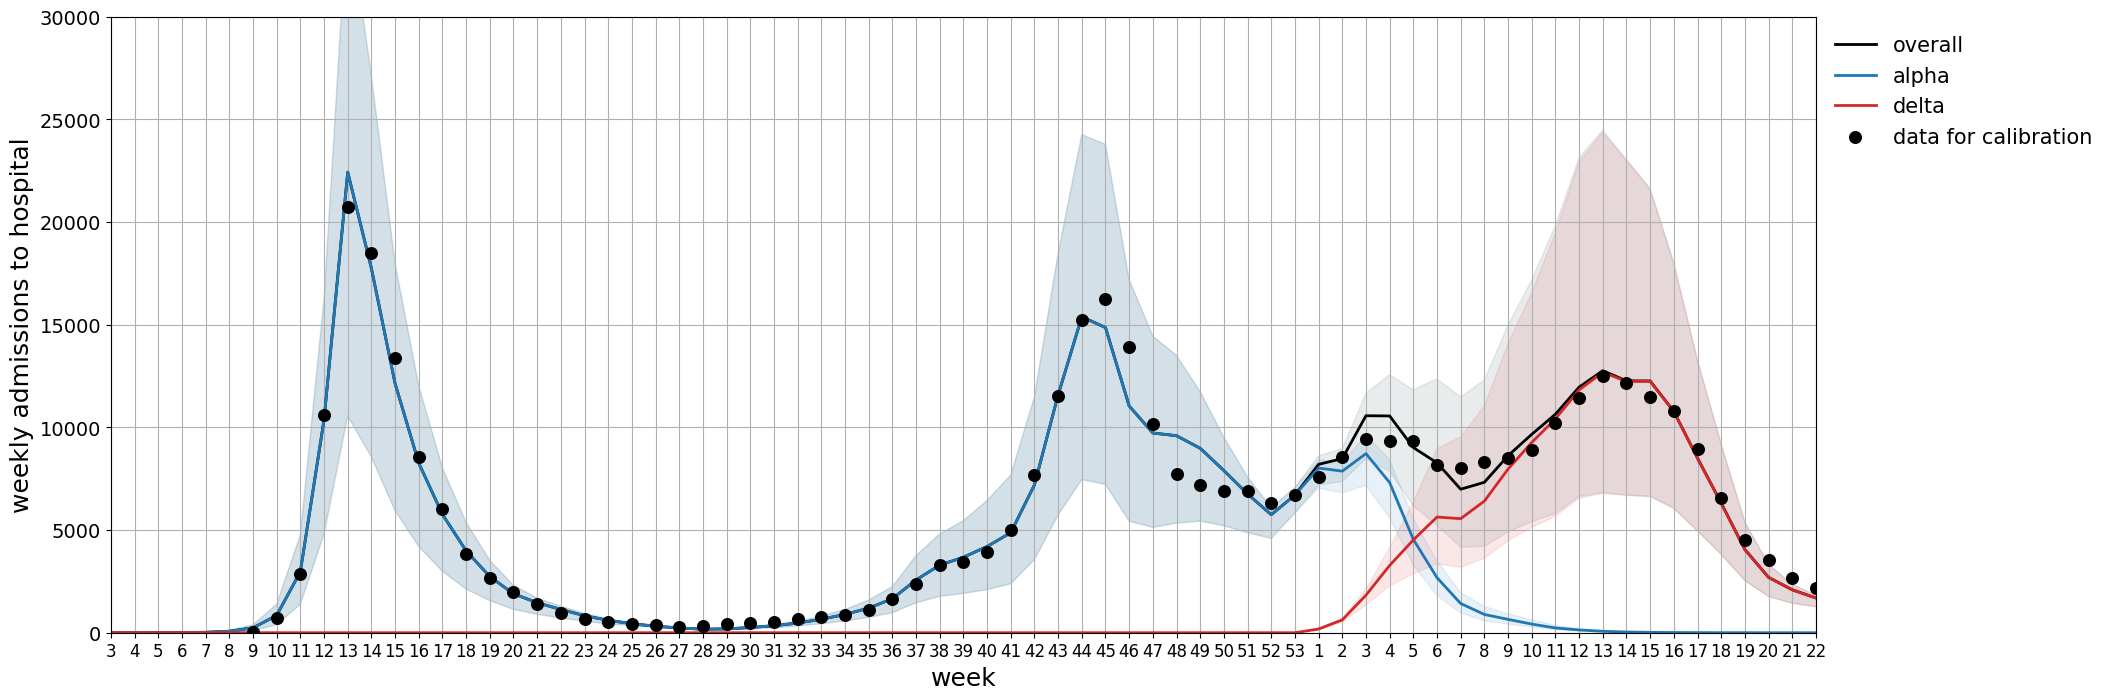

In [51]:
width=2

folder = 'output_hosp_adm'  

fig, ax = plt.subplots(1, 1, figsize=(22,8))

df = pd.read_csv('{}/new_H_{}_scenario_fit_runs{}_both_both.csv'.format(folder, codice_regione, n_runs))
df = aggregate_week(df)
ax.plot(df.index.values, df['median'].values,color='black',linestyle='-',linewidth=width,label='overall')
ax.fill_between(df.index.values,df['p1'].values, df['p2'].values,color="#264653", alpha=0.1)  
plt.xticks(df.index, df.week)

df = pd.read_csv('{}/new_H_{}_scenario_fit_runs{}_wild_both.csv'.format(folder, codice_regione, n_runs))
df = aggregate_week(df)
ax.plot(df.index.values, df['median'].values,color='tab:blue',linestyle='-',linewidth=width,label='alpha')
ax.fill_between(df.index,df['p1'].values, df['p2'].values,color='tab:blue', alpha=0.1)  

df = pd.read_csv('{}/new_H_{}_scenario_fit_runs{}_VOC_both.csv'.format(folder, codice_regione, n_runs))
df = aggregate_week(df)
ax.plot(df.index.values, df['median'].values,color='tab:red',linestyle='-',linewidth=width,label='delta')
ax.fill_between(df.index,df['p1'].values, df['p2'].values,color='tab:red', alpha=0.1)  

plt.xticks(df.index, df.week, fontsize=12)

plt.yticks( fontsize=14)
ax.set_ylabel('weekly admissions to hospital', fontsize=18)

plt.ylim(0,30000)
plt.xlim(0,72)
ax.scatter(range(6,len(H_adm_week)+6), H_adm_week['hosp_pred'], color='black',s=70,zorder=10,label='data for calibration')
#ax.scatter(H_adm_week['abs_week'].iloc[-1]-(53+starting_week-1),H_adm_week['hosp_pred'].iloc[-1], edgecolor='black', facecolor='red',s=70,zorder=10,label='new data')

leg = ax.legend(fontsize=15, loc='upper left', bbox_to_anchor=(1,1))
leg.get_frame().set_linewidth(0.0)
leg.get_frame().set_color('None')        
plt.subplots_adjust(hspace = 0.1)
plt.xlabel('week',fontsize=18)

plt.grid()

plt.savefig('{}/plot_curve.png'.format(folder), bbox_inches='tight',dpi=300)

## extract configuration to initialize alpha vs delta model

In [52]:
folder = 'output_extract_config'
from pathlib import Path
Path(folder).mkdir(parents=True, exist_ok=True)

In [53]:
days_to_extract = calendar[calendar[0]=='2021-06-06'][0].apply(lambda x: x.strftime('%Y-%m-%d')).values
days_to_extract

array(['2021-06-06'], dtype=object)

In [54]:
for day in days_to_extract:
    
    res = {}
    for comp in ['E_', 'Ip_', 'Ias_', 'Ips_', 'Ims_', 'Iss_', 'W_', 'H_', 'R_']:
        for age in ['ch', 'te', 'ad', 'se']:
            res[comp+age] = out[comp+age].iloc[calendar[calendar[0]==day].index[0]]
    
    pd.DataFrame(res).to_csv('./{}/config_{}.csv'.format(folder,day), index=False)